(2/2) Creating Thicket: 100%|██████████| 254/254 [00:01<00:00, 178.61it/s]
/opt/homebrew/lib/python3.12/site-packages/thicket/ensemble.py:409: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace({numerical_fill_value: None}, inplace=True)


NameError: name 'procs' is not defined

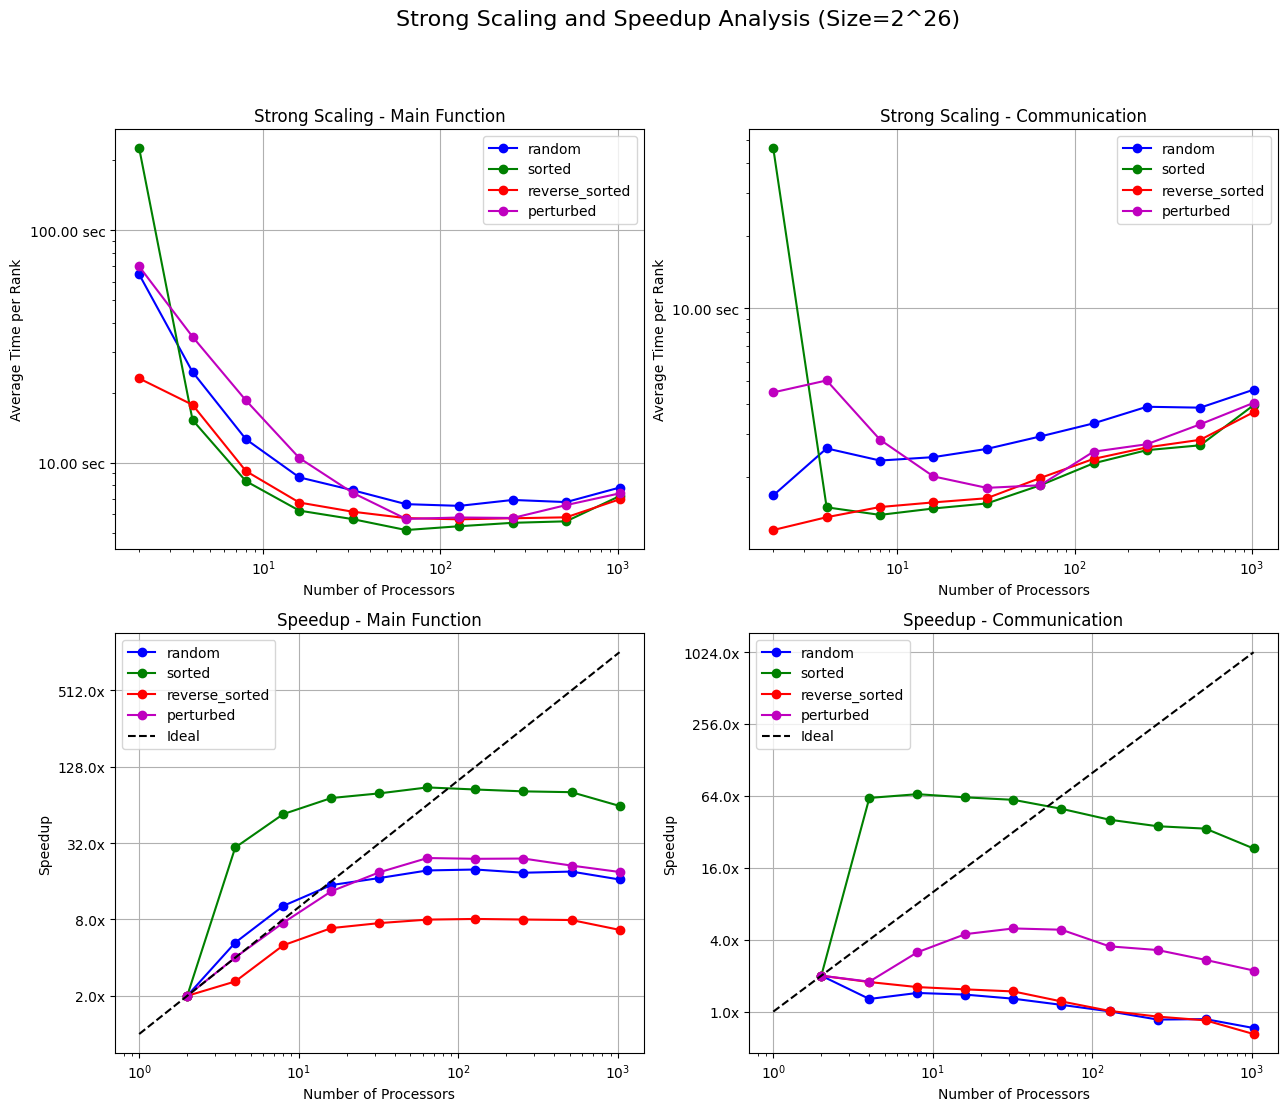

In [5]:
import sys
sys.path.append("/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
sys.path.append("/scratch/group/csce435-f24/thicket")
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import thicket as th

# Load files
tk = th.Thicket.from_caliperreader(glob("calipers/*.cali"))

# Get main function data
main_data = tk.dataframe[tk.dataframe['name'] == 'main'].copy()
# Get communication data
comm_data = tk.dataframe[tk.dataframe['name'] == 'comm'].copy()

# Create analysis DataFrames for both main and comm
def create_analysis_df(data):
    analysis_df = pd.DataFrame()
    analysis_df['filename'] = tk.metadata['spot:output']
    analysis_df['num_procs'] = tk.metadata['num_procs']
    analysis_df['input_size'] = tk.metadata['input_size']
    analysis_df['input_type'] = tk.metadata['input_type']
    analysis_df['avg_time'] = data['Avg time/rank'].values
    return analysis_df

main_analysis_df = create_analysis_df(main_data)
comm_analysis_df = create_analysis_df(comm_data)

# Filter for size 2^26
target_size = 67108864
main_analysis_df = main_analysis_df[main_analysis_df['input_size'] == target_size]
comm_analysis_df = comm_analysis_df[comm_analysis_df['input_size'] == target_size]

# Create the 4 plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Strong Scaling and Speedup Analysis (Size=2^26)', fontsize=16)

input_types = ['random', 'sorted', 'reverse_sorted', 'perturbed']
colors = ['b', 'g', 'r', 'm']

# Plot 1: Strong Scaling for Main (unchanged)
for input_type, color in zip(input_types, colors):
    data = main_analysis_df[main_analysis_df['input_type'] == input_type].sort_values('num_procs')
    axes[0,0].plot(data['num_procs'], data['avg_time'], 'o-', color=color, label=input_type)

axes[0,0].set_title('Strong Scaling - Main Function')
axes[0,0].set_xlabel('Number of Processors')
axes[0,0].set_ylabel('Average Time per Rank')
axes[0,0].grid(True)
axes[0,0].set_xscale('log')
axes[0,0].set_yscale('log')
axes[0,0].legend()
axes[0,0].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f sec'))

# Plot 2: Strong Scaling for Communication (unchanged)
for input_type, color in zip(input_types, colors):
    data = comm_analysis_df[comm_analysis_df['input_type'] == input_type].sort_values('num_procs')
    axes[0,1].plot(data['num_procs'], data['avg_time'], 'o-', color=color, label=input_type)

axes[0,1].set_title('Strong Scaling - Communication')
axes[0,1].set_xlabel('Number of Processors')
axes[0,1].set_ylabel('Average Time per Rank')
axes[0,1].grid(True)
axes[0,1].set_xscale('log')
axes[0,1].set_yscale('log')
axes[0,1].legend()
axes[0,1].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f sec'))

# Plot 3: Speedup for Main (modified)
for input_type, color in zip(input_types, colors):
    data = main_analysis_df[main_analysis_df['input_type'] == input_type].sort_values('num_procs')
    if not data.empty:
        # Assume single processor time is double the time of the first available measurement
        base_time = data['avg_time'].iloc[0] * 2
        speedup = base_time / data['avg_time']
        axes[1,0].plot(data['num_procs'], speedup, 'o-', color=color, label=input_type)

# Extend ideal speedup line to include theoretical single processor point
min_procs = min(data['num_procs'])
max_procs = max(data['num_procs'])
ideal_procs = [1] + list(data['num_procs'])
ideal_speedup = [1] + list(data['num_procs'])
axes[1,0].plot(ideal_procs, ideal_speedup, 'k--', label='Ideal')

axes[1,0].set_title('Speedup - Main Function')
axes[1,0].set_xlabel('Number of Processors')
axes[1,0].set_ylabel('Speedup')
axes[1,0].grid(True)
axes[1,0].legend()
axes[1,0].set_xscale('log')
axes[1,0].set_yscale('log', base=2)
axes[1,0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}x'))

# Plot 4: Speedup for Communication (modified)
for input_type, color in zip(input_types, colors):
    data = comm_analysis_df[comm_analysis_df['input_type'] == input_type].sort_values('num_procs')
    if not data.empty:
        # Assume single processor time is double the time of the first available measurement
        base_time = data['avg_time'].iloc[0] * 2
        speedup = base_time / data['avg_time']
        axes[1,1].plot(data['num_procs'], speedup, 'o-', color=color, label=input_type)

# Extend ideal speedup line to include theoretical single processor point
axes[1,1].plot(ideal_procs, ideal_speedup, 'k--', label='Ideal')

axes[1,1].set_title('Speedup - Communication')
axes[1,1].set_xlabel('Number of Processors')
axes[1,1].set_ylabel('Speedup')
axes[1,1].grid(True)
axes[1,1].legend()
axes[1,1].set_xscale('log')
axes[1,1].set_yscale('log', base=2)
axes[1,1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}x'))

# Set x-ticks for all plots, including the theoretical single processor point
for ax in axes.flat:
    ax.set_xticks([1] + list(procs))
    ax.set_xticklabels(['1'] + [str(x) for x in procs])

plt.tight_layout()
plt.show()

# Print detailed statistics
print(f"\nDetailed Statistics for Size {target_size}:")
print("\nMain Function Average Times (with theoretical 1-processor time):")
print("Input Type\tThreads\tAvg Time/Rank")
for input_type in input_types:
    data = main_analysis_df[main_analysis_df['input_type'] == input_type].sort_values('num_procs')
    if not data.empty:
        theoretical_time = data['avg_time'].iloc[0] * 2
        print(f"{input_type}\t1\t{theoretical_time:.3f} (theoretical)")
        for _, row in data.iterrows():
            print(f"{input_type}\t{row['num_procs']}\t{row['avg_time']:.3f}")

print("\nCommunication Average Times (with theoretical 1-processor time):")
print("Input Type\tThreads\tAvg Time/Rank")
for input_type in input_types:
    data = comm_analysis_df[comm_analysis_df['input_type'] == input_type].sort_values('num_procs')
    if not data.empty:
        theoretical_time = data['avg_time'].iloc[0] * 2
        print(f"{input_type}\t1\t{theoretical_time:.3f} (theoretical)")
        for _, row in data.iterrows():
            print(f"{input_type}\t{row['num_procs']}\t{row['avg_time']:.3f}")

(2/2) Creating Thicket: 100%|██████████| 11/11 [00:00<00:00, 1506.23it/s]
/opt/homebrew/lib/python3.12/site-packages/thicket/ensemble.py:409: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace({numerical_fill_value: None}, inplace=True)


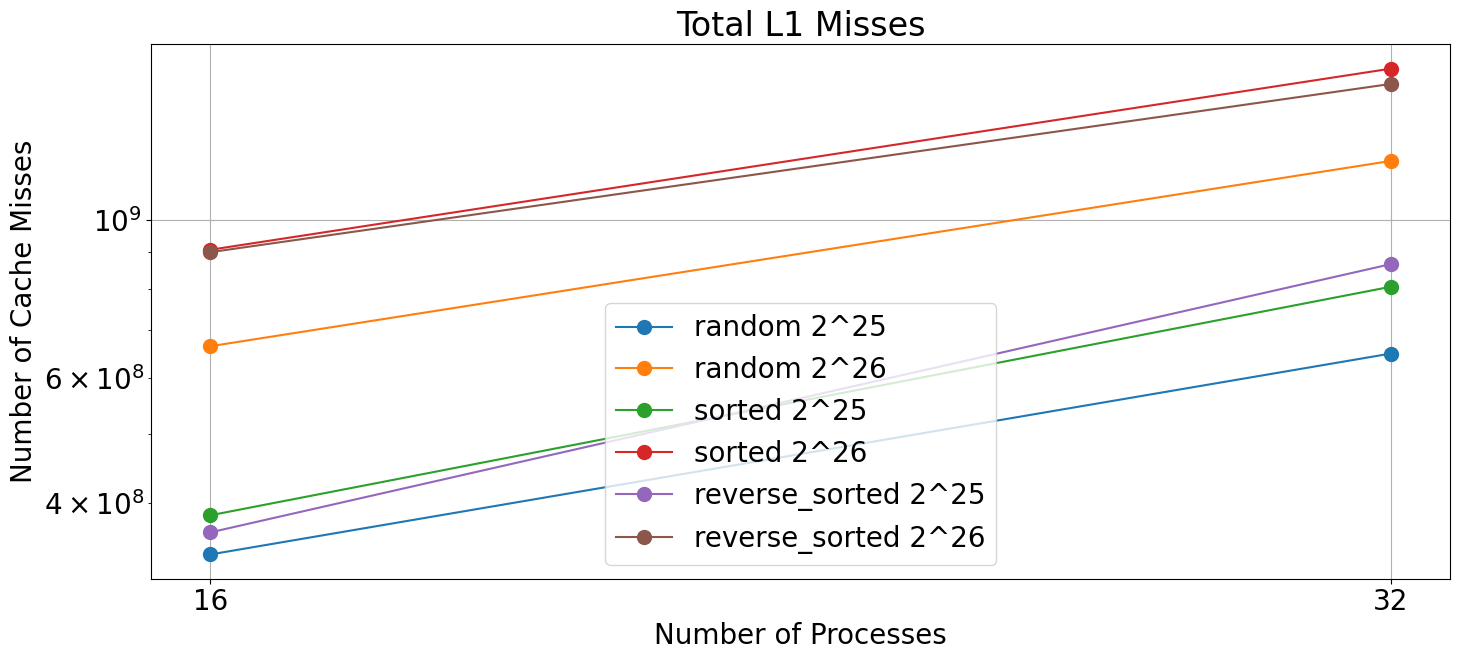


Total L1 Misses Statistics:
---------------------------------------
Input Type       Processes    2^25 Cache Misses        2^26 Cache Misses
random          16           3.39e+08               6.64e+08
random          32           6.48e+08               1.21e+09
sorted          16           3.84e+08               9.07e+08
sorted          32           8.05e+08               1.63e+09
reverse_sorted  16           3.64e+08               9.00e+08
reverse_sorted  32           8.66e+08               1.55e+09
perturbed       16           N/A                    N/A
perturbed       32           N/A                    N/A


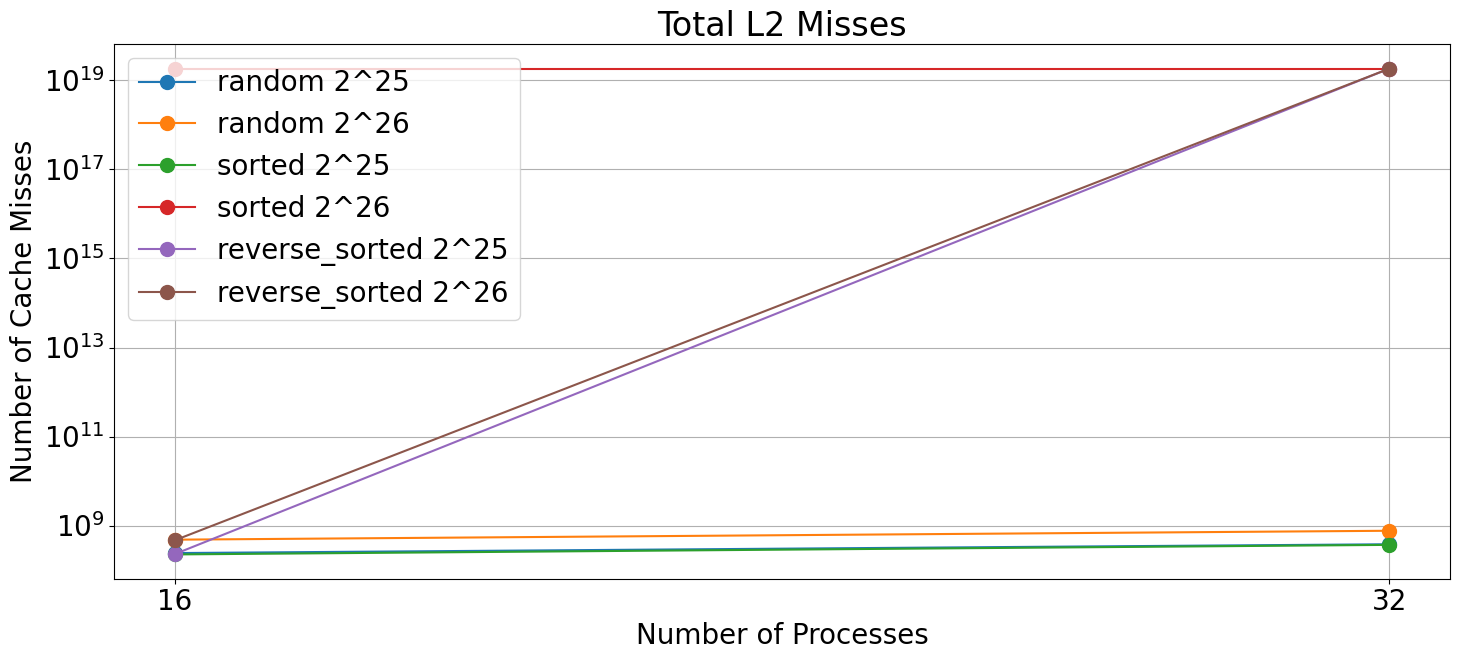


Total L2 Misses Statistics:
---------------------------------------
Input Type       Processes    2^25 Cache Misses        2^26 Cache Misses
random          16           2.41e+08               4.81e+08
random          32           3.80e+08               7.64e+08
sorted          16           2.24e+08               1.84e+19
sorted          32           3.68e+08               1.84e+19
reverse_sorted  16           2.29e+08               4.68e+08
reverse_sorted  32           1.84e+19               1.84e+19
perturbed       16           N/A                    N/A
perturbed       32           N/A                    N/A


In [ ]:
import sys
sys.path.append("/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
sys.path.append("/scratch/group/csce435-f24/thicket")
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import thicket as th

# Load files
caliper_files = glob("cache_calis/*.cali")
tk = th.Thicket.from_caliperreader(caliper_files)
main_data = tk.dataframe[tk.dataframe['name'] == 'main'].copy().reset_index()

# Create analysis DataFrame
analysis_df = pd.DataFrame()
analysis_df['filename'] = tk.metadata['spot:output']
analysis_df['num_procs'] = tk.metadata['num_procs']
analysis_df['input_size'] = tk.metadata['input_size']
analysis_df['input_type'] = tk.metadata['input_type']
analysis_df['total_L1_misses'] = main_data['Total L1 misses'].values
analysis_df['total_L2_misses'] = main_data['Total L2 misses'].values

# Clean extremely large values (might be errors)
max_reasonable_value = 1e15
analysis_df.loc[analysis_df['total_L2_misses'] > max_reasonable_value, 'total_L2_misses'] = np.nan

# Set plot parameters
plt.rcParams.update({"font.size": 14})

def plot_cache_misses_for_size(data, size):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    input_types = ['sorted', 'random', 'reverse_sorted']
    colors = ['blue', 'green', 'red']
    
    # Filter data for this size
    size_data = data[data['input_size'] == size]
    
    for input_type, color in zip(input_types, colors):
        type_data = size_data[size_data['input_type'] == input_type].sort_values('num_procs')
        if not type_data.empty:
            # Plot L1 misses
            ax.plot(
                type_data['num_procs'],
                type_data['total_L1_misses'],
                'o-',
                color=color,
                label=f'L1 misses - {input_type}',
                linewidth=2
            )
            # Plot L2 misses with dashed lines
            l2_data = type_data[type_data['total_L2_misses'].notna()]
            if not l2_data.empty:
                ax.plot(
                    l2_data['num_procs'],
                    l2_data['total_L2_misses'],
                    'o--',  # Use dashed line style for L2
                    color=color,
                    label=f'L2 misses - {input_type}',
                    alpha=0.5,
                    linewidth=2
                )
    
    ax.set_title(f'Cache Misses for 2^{size.bit_length()-1} elements', pad=20)
    ax.set_xlabel('Number of Processes')
    ax.set_ylabel('Number of Cache Misses')
    
    # Format y-axis with scientific notation
    ax.yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    # Move the legend up a bit
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_xticks([16, 32])
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics with improved formatting
    print(f"\nCache Misses Statistics for Size 2^{size.bit_length()-1}:")
    print("---------------------------------------")
    print(f"{'Input Type':<15} {'Processes':<10} {'L1 Cache Misses':<20} {'L2 Cache Misses':<20}")
    
    for input_type in input_types:
        for num_procs in [16, 32]:
            data_point = size_data[
                (size_data['input_type'] == input_type) & 
                (size_data['num_procs'] == num_procs)
            ]
            if not data_point.empty:
                l1_misses = data_point['total_L1_misses'].iloc[0]
                l2_misses = data_point['total_L2_misses'].iloc[0]
                
                l1_str = f"{l1_misses:.2e}" if not pd.isna(l1_misses) else "N/A"
                l2_str = f"{l2_misses:.2e}" if not pd.isna(l2_misses) else "N/A"
                
                print(f"{input_type:<15} {num_procs:<10d} {l1_str:<20} {l2_str:<20}")

# Plot cache misses for each size
sizes = [33554432, 67108864]  # 2^25 and 2^26
for size in sizes:
    plot_cache_misses_for_size(analysis_df, size)

In [ ]:
# After loading the data, add these diagnostic prints:
print("\nChecking L2 cache miss data:")
print("\nOriginal L2 cache miss values from main_data:")
print(main_data[['name', 'Total L2 misses']].to_string())

print("\nExtremely large L2 cache miss values (>1e15):")
print(main_data[main_data['Total L2 misses'] > 1e15][['name', 'Total L2 misses']].to_string())

print("\nFinal L2 cache miss values in analysis_df:")
print(analysis_df[['input_type', 'num_procs', 'total_L2_misses']].to_string())

(2/2) Creating Thicket: 100%|██████████| 254/254 [00:01<00:00, 168.07it/s]



Generating Strong Scaling plots...


/opt/homebrew/lib/python3.12/site-packages/thicket/ensemble.py:409: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace({numerical_fill_value: None}, inplace=True)


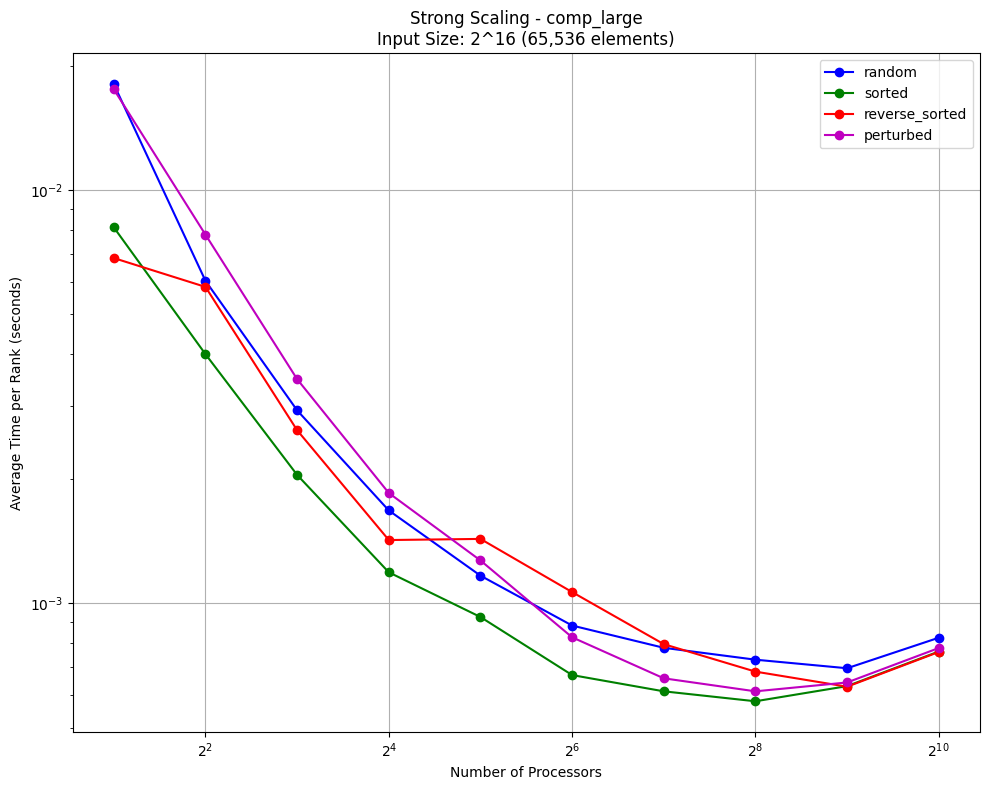

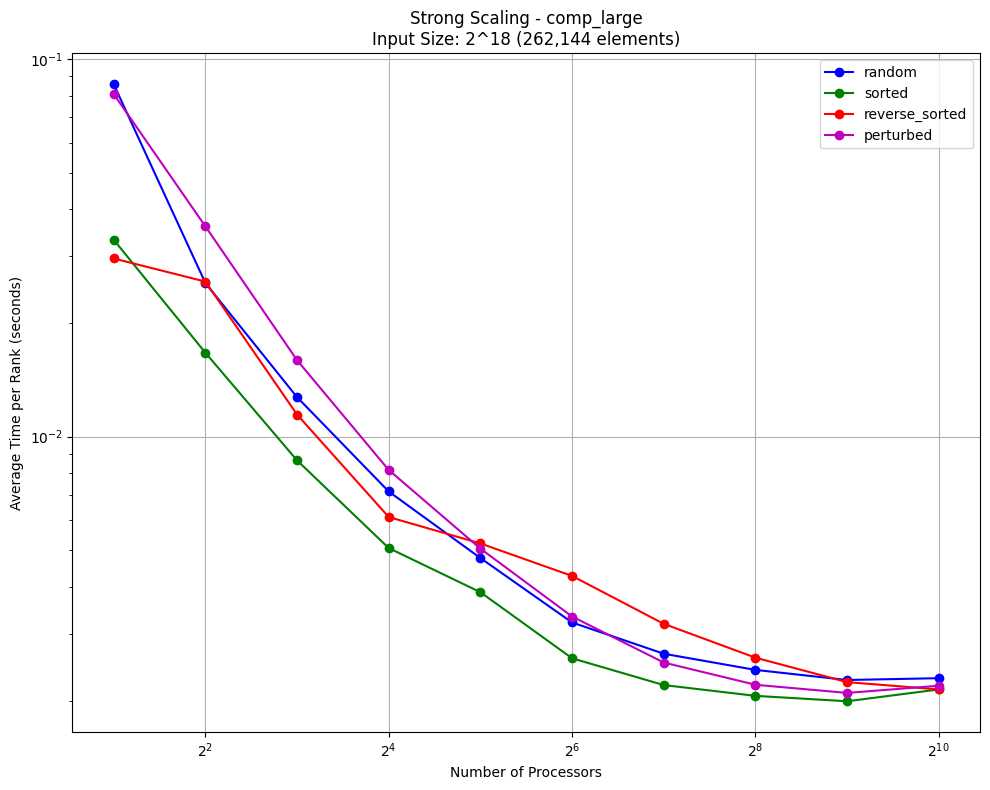

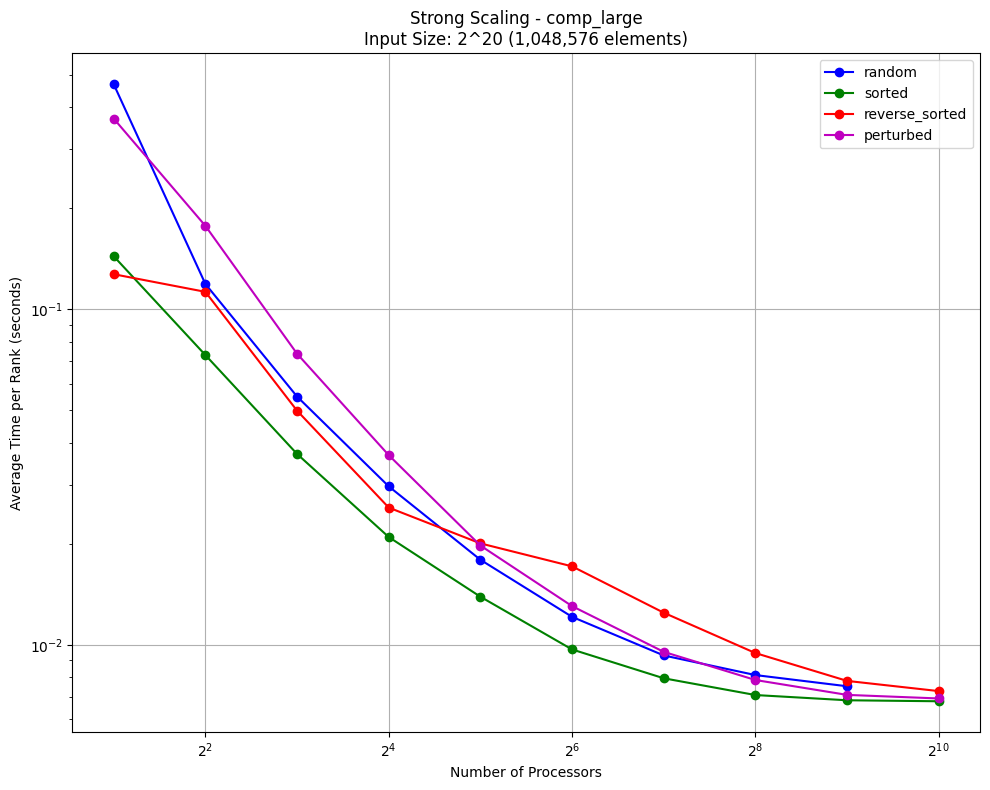

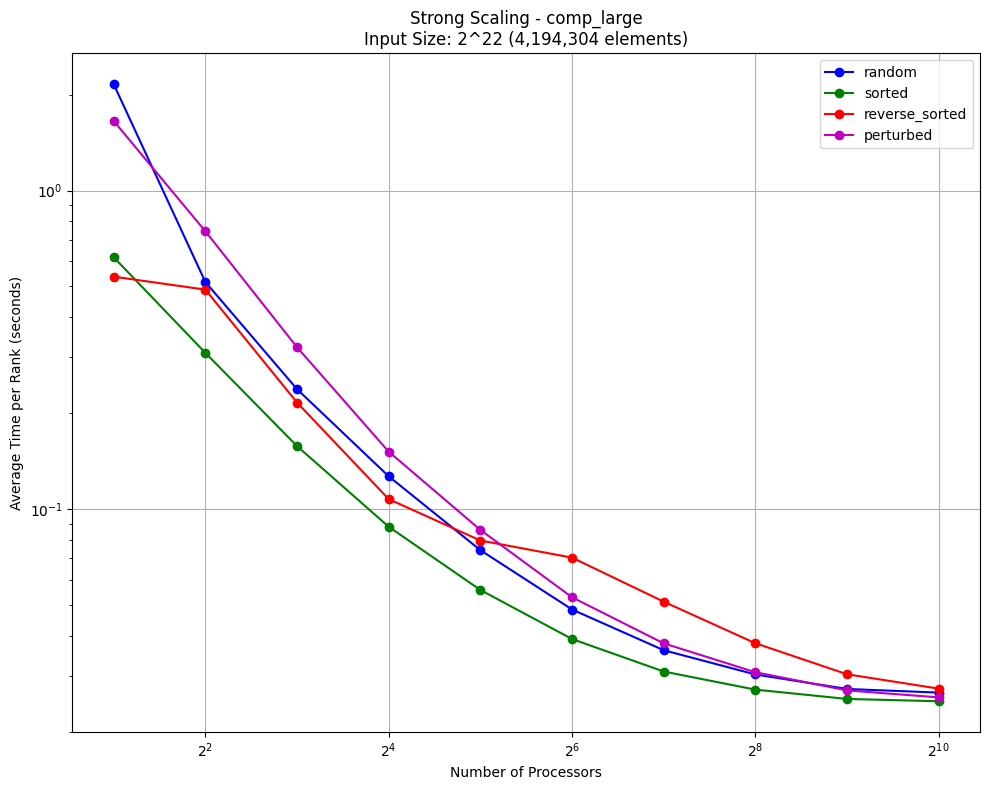

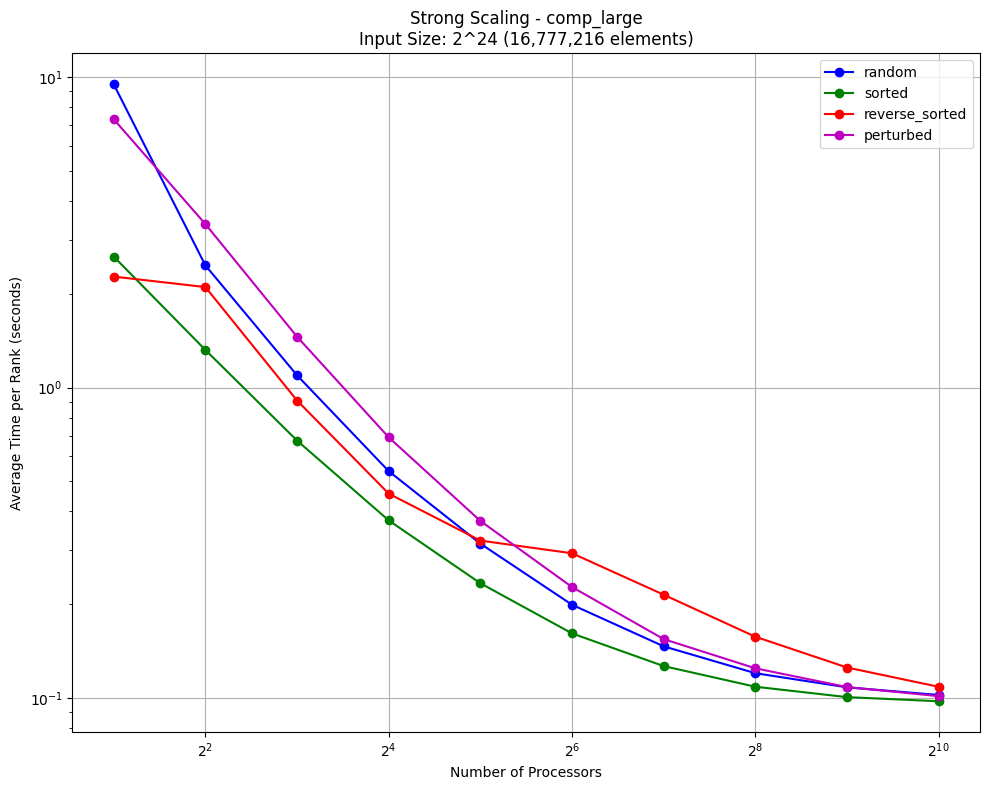

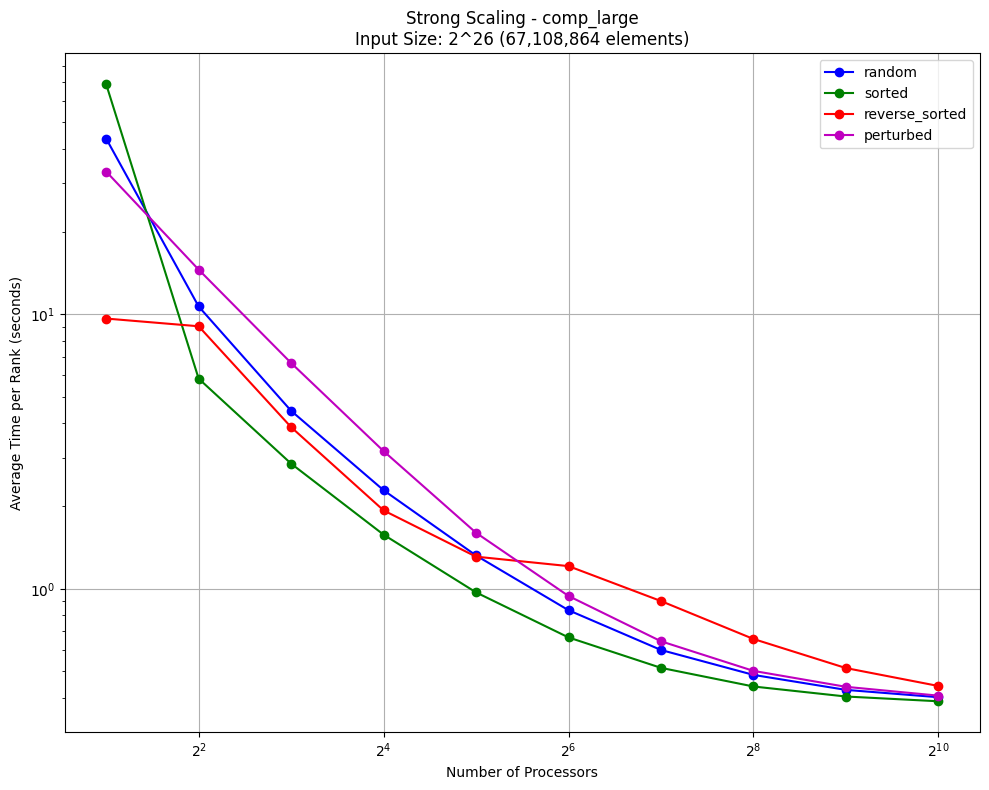

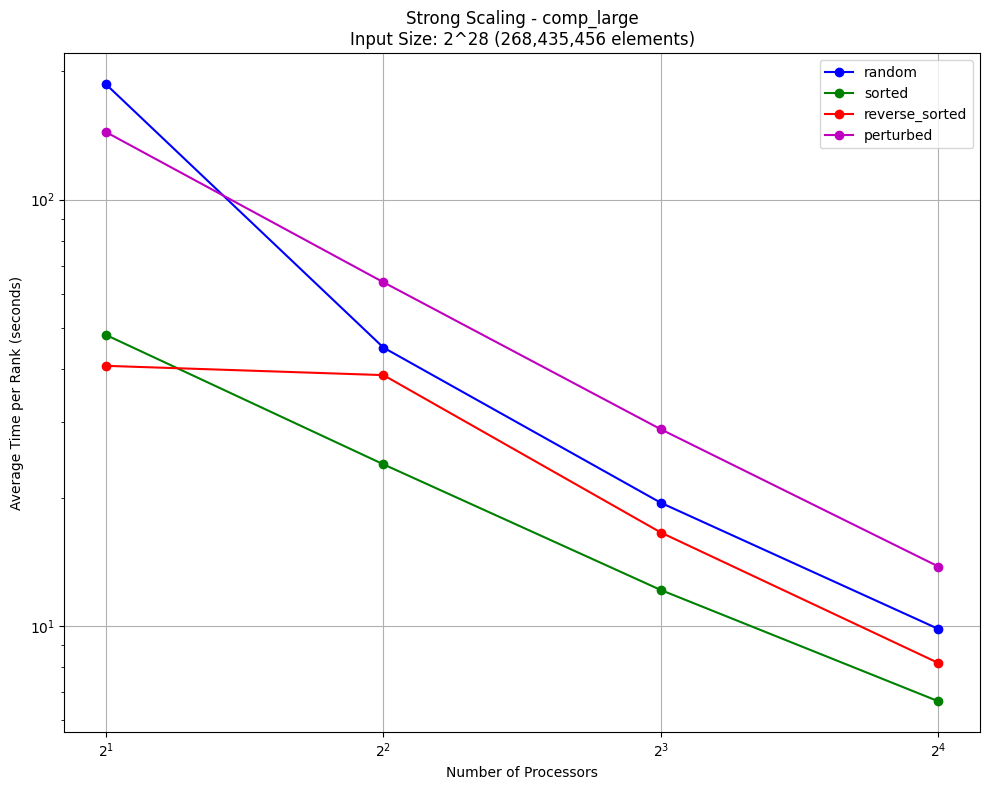

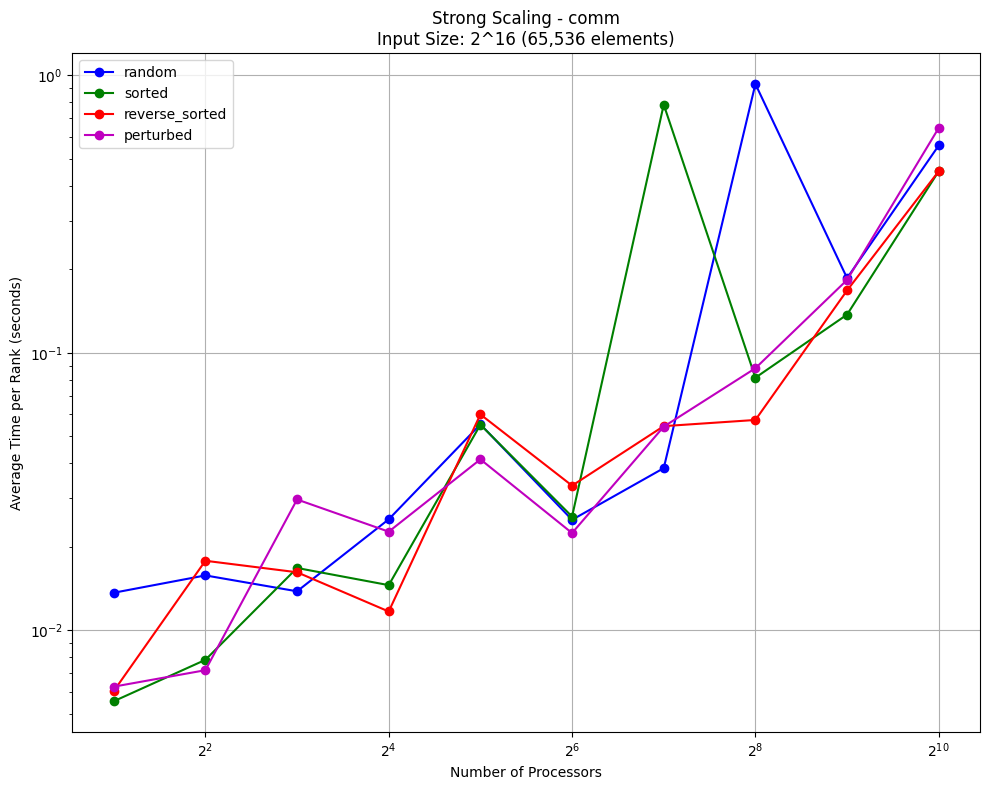

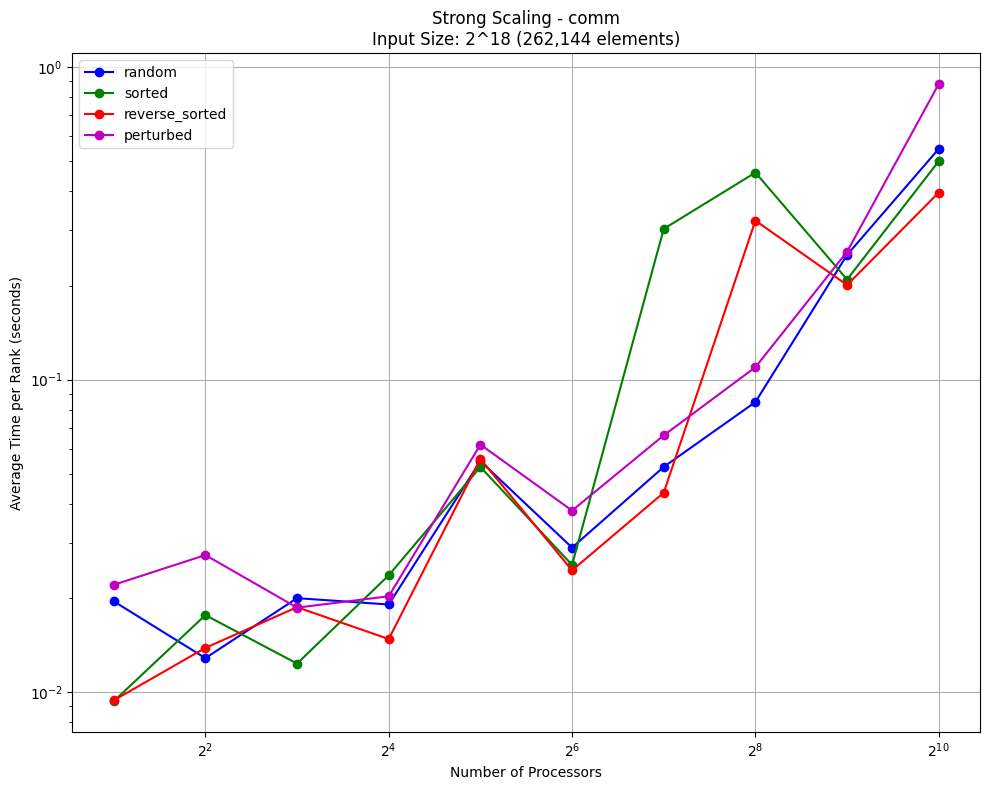

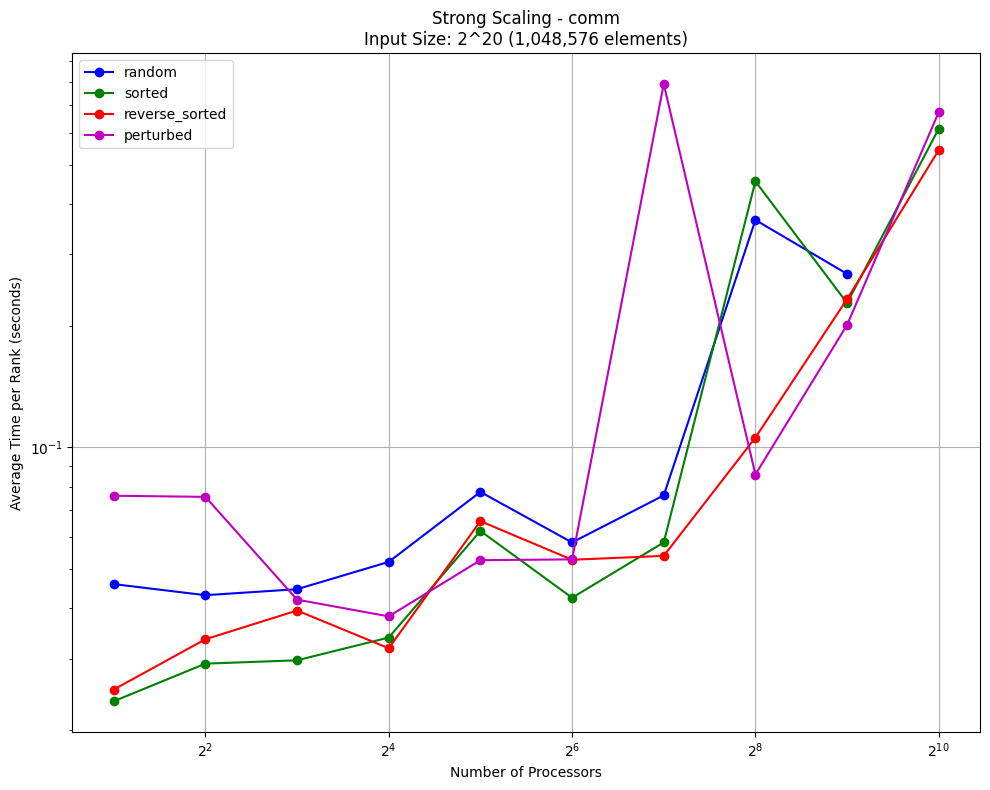

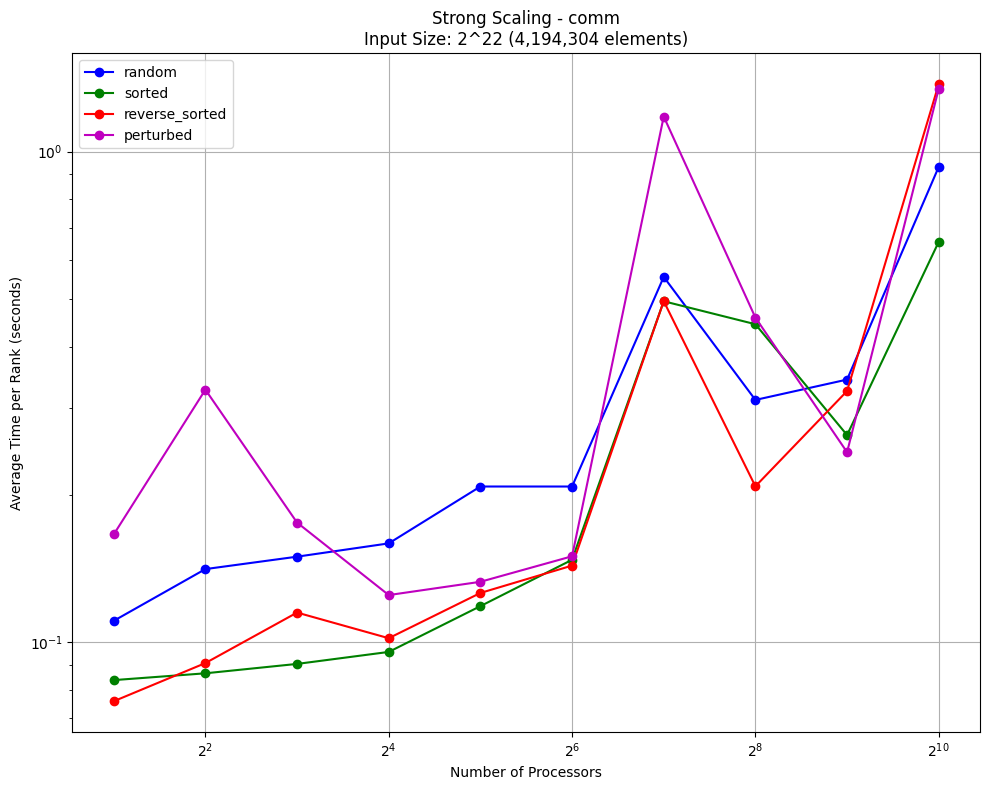

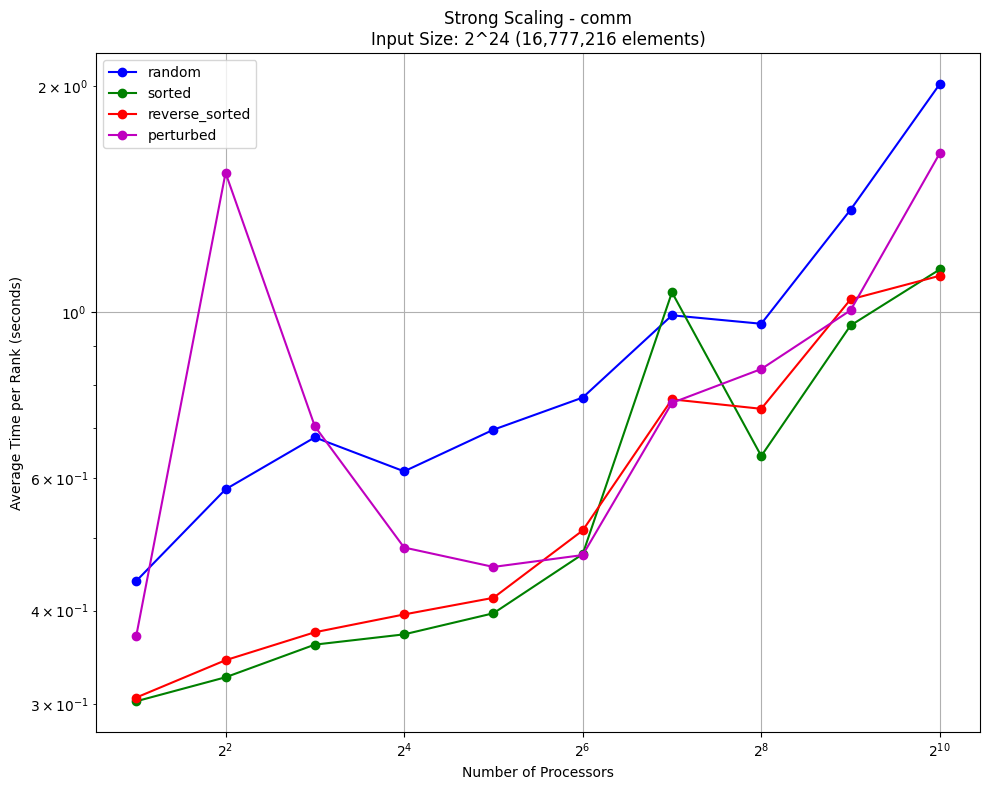

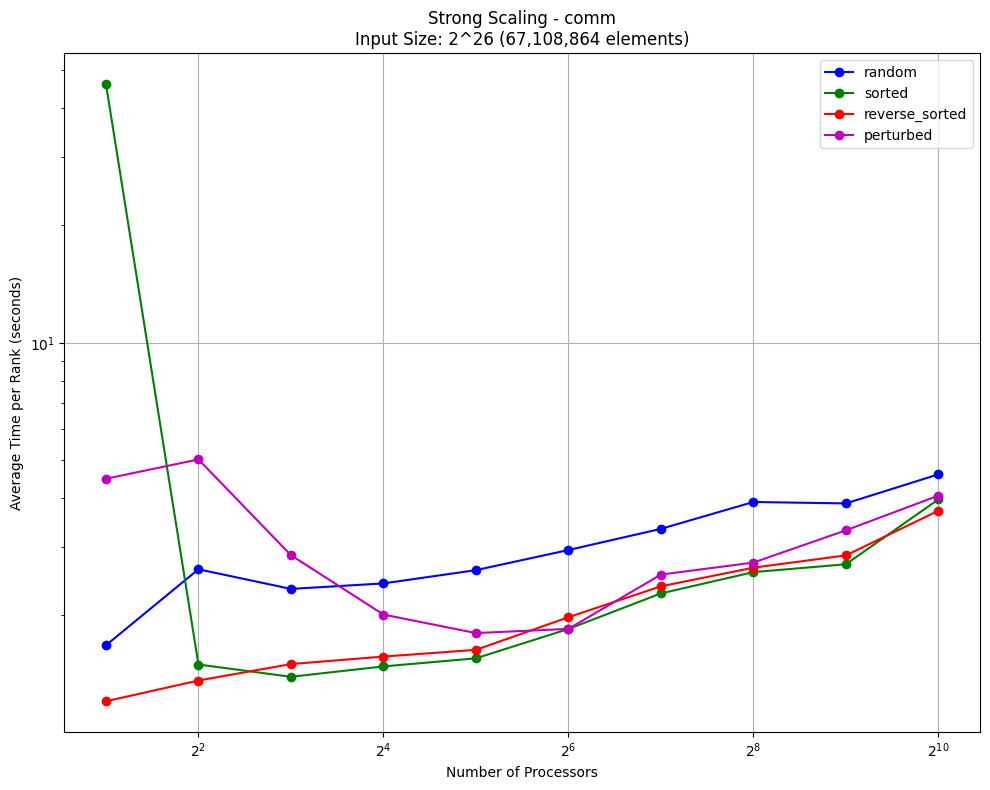

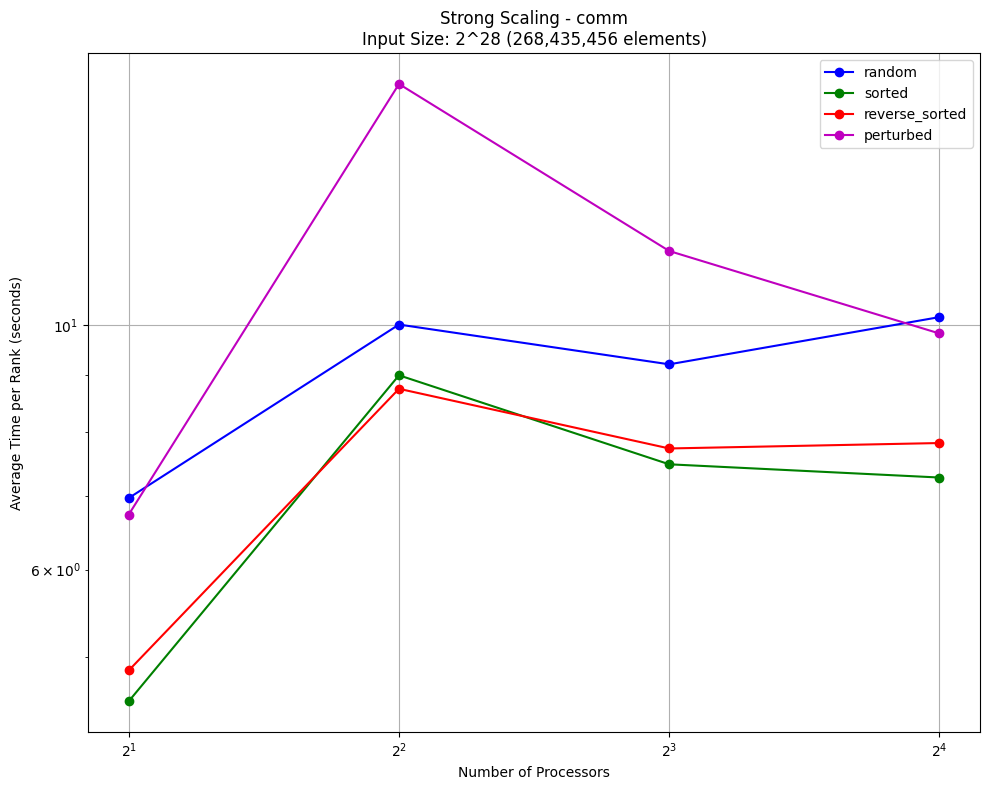

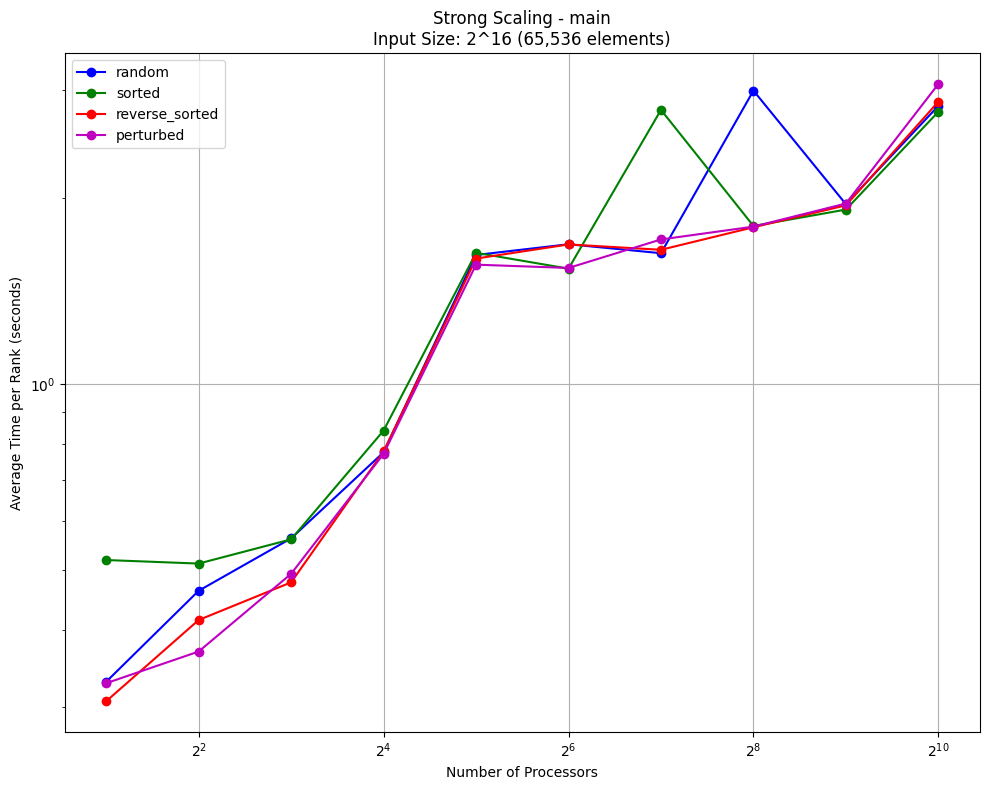

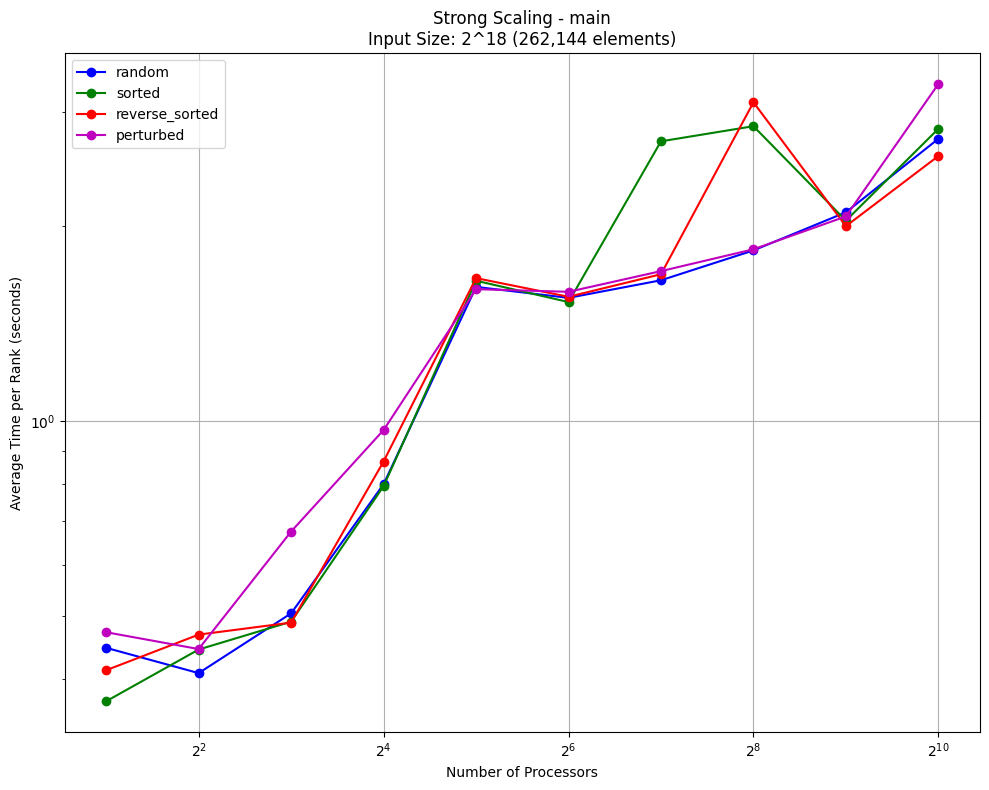

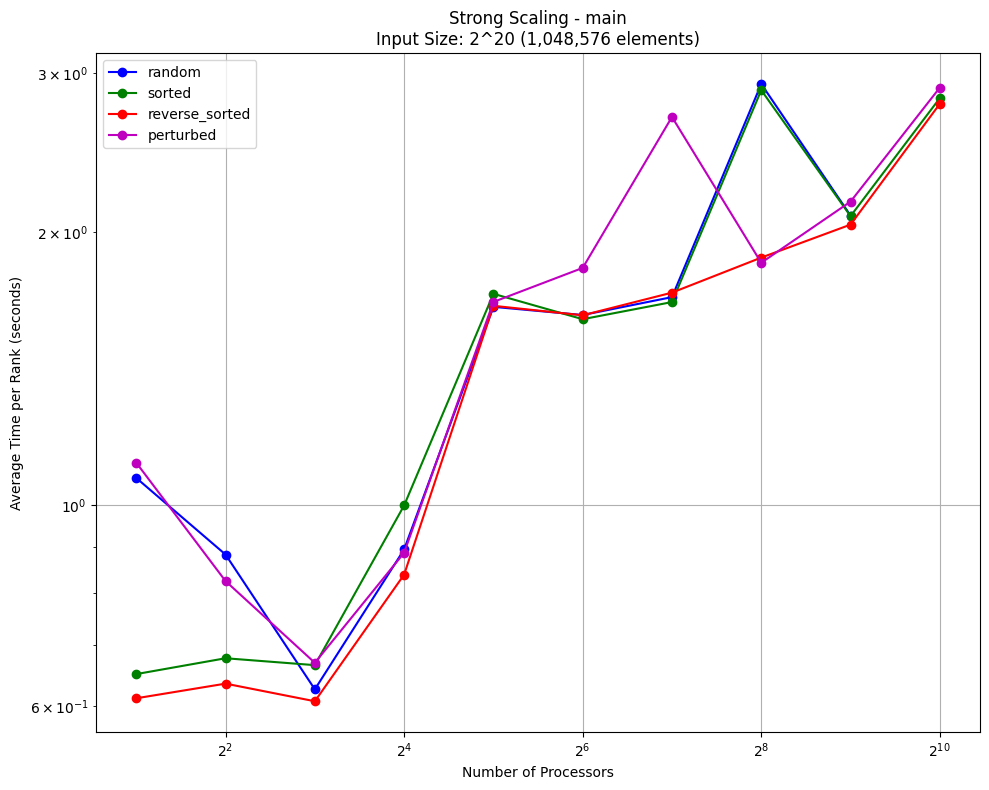

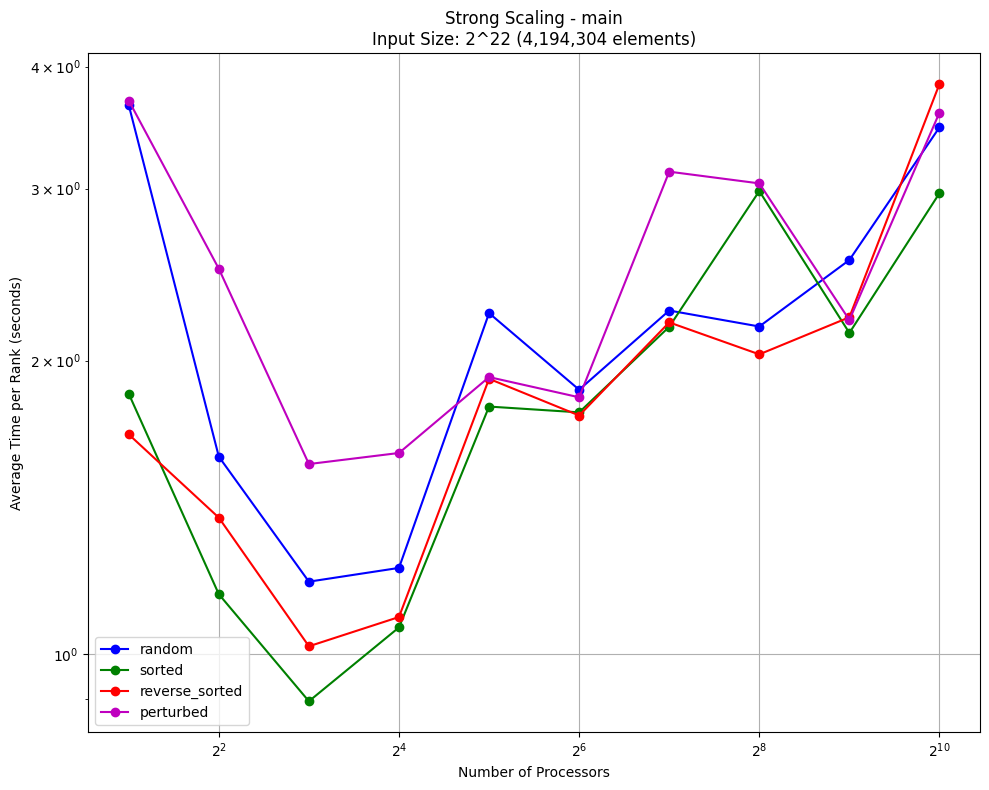

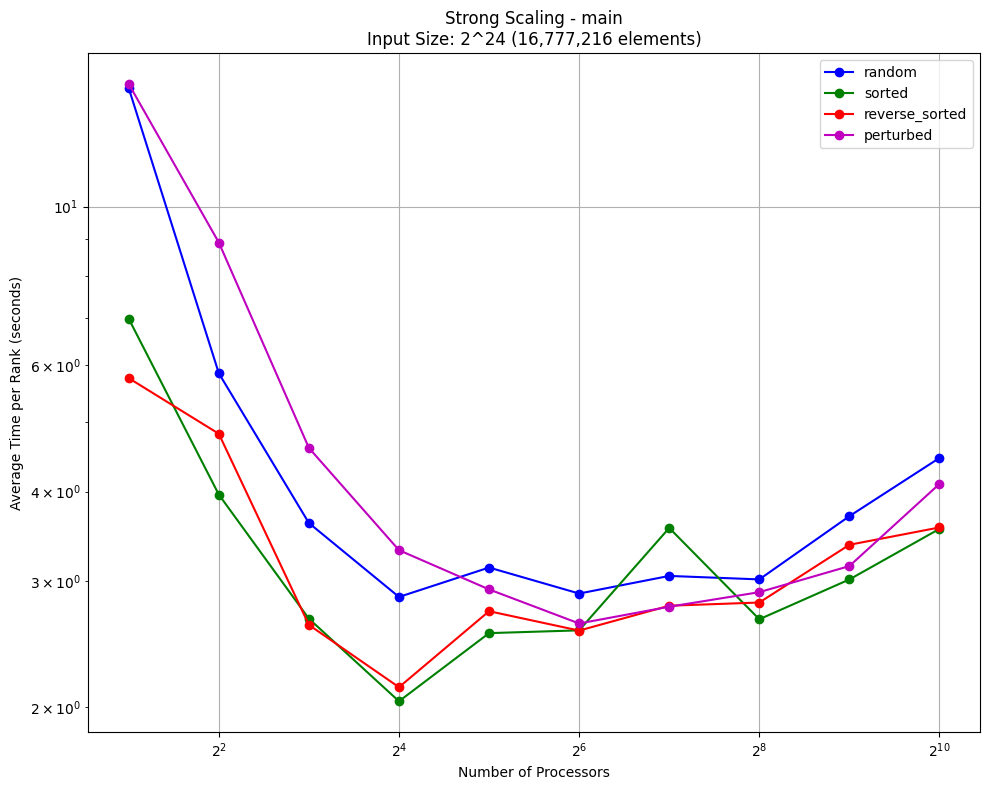

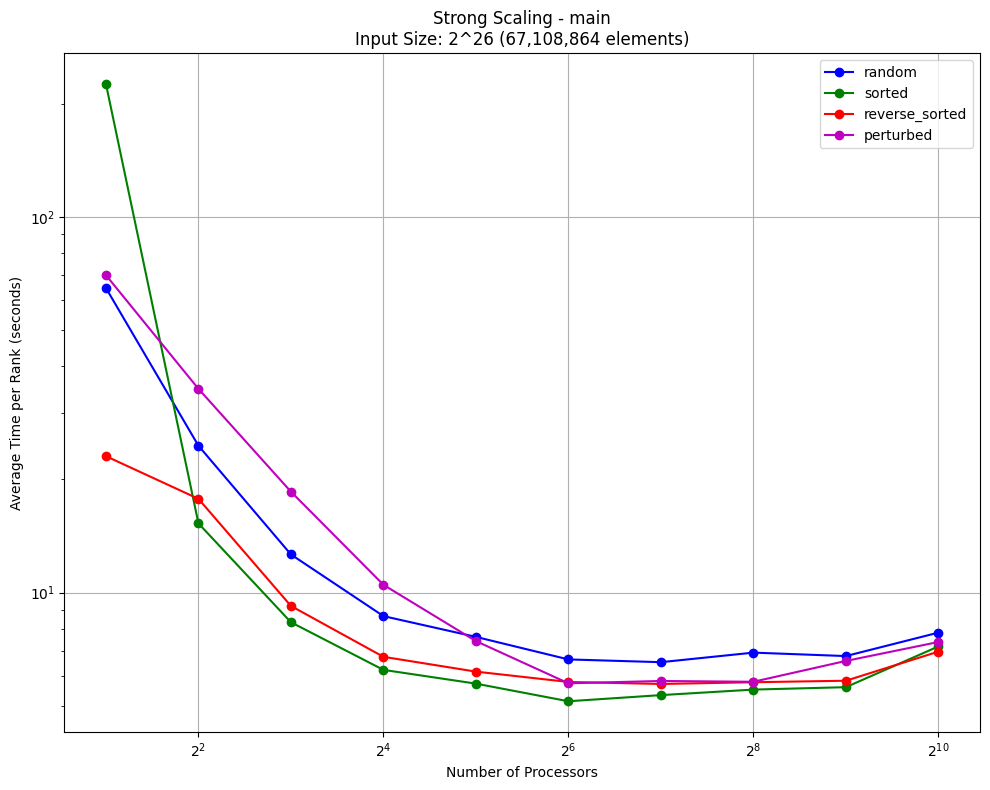

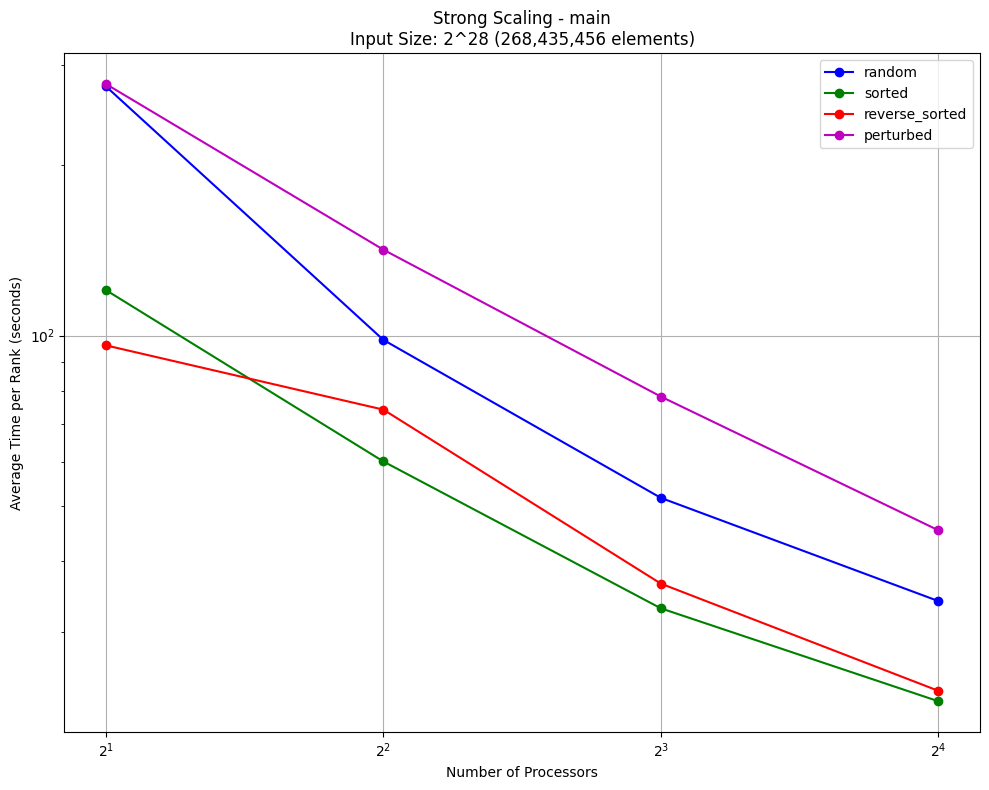


Generating Speedup plots...


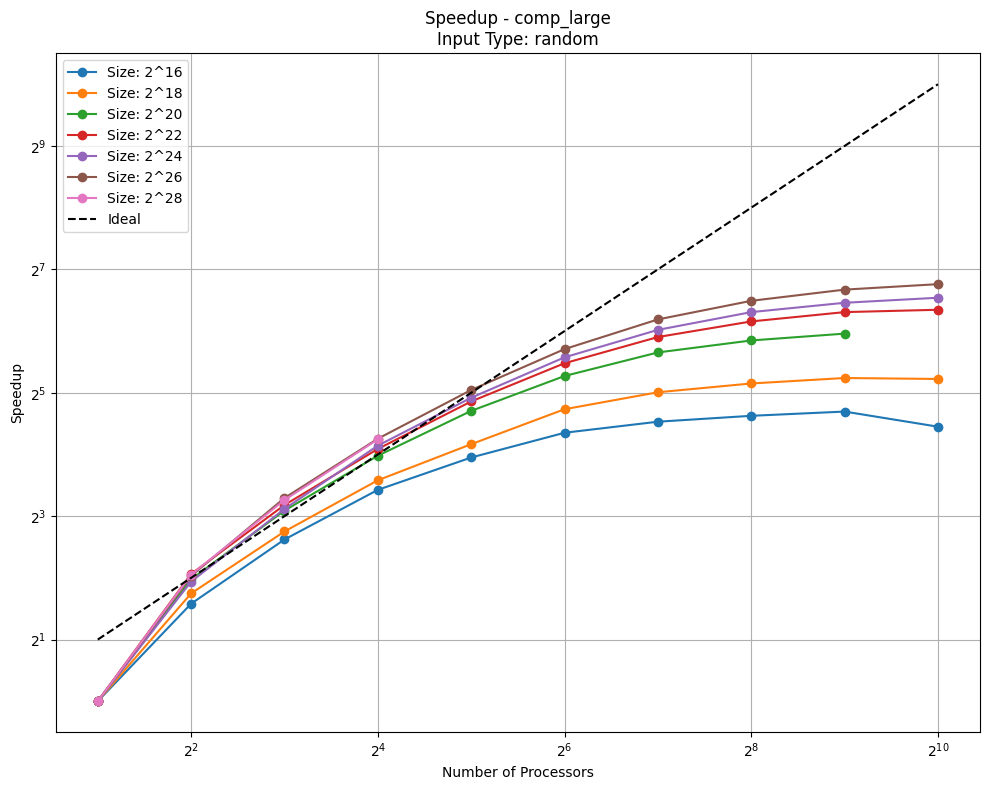

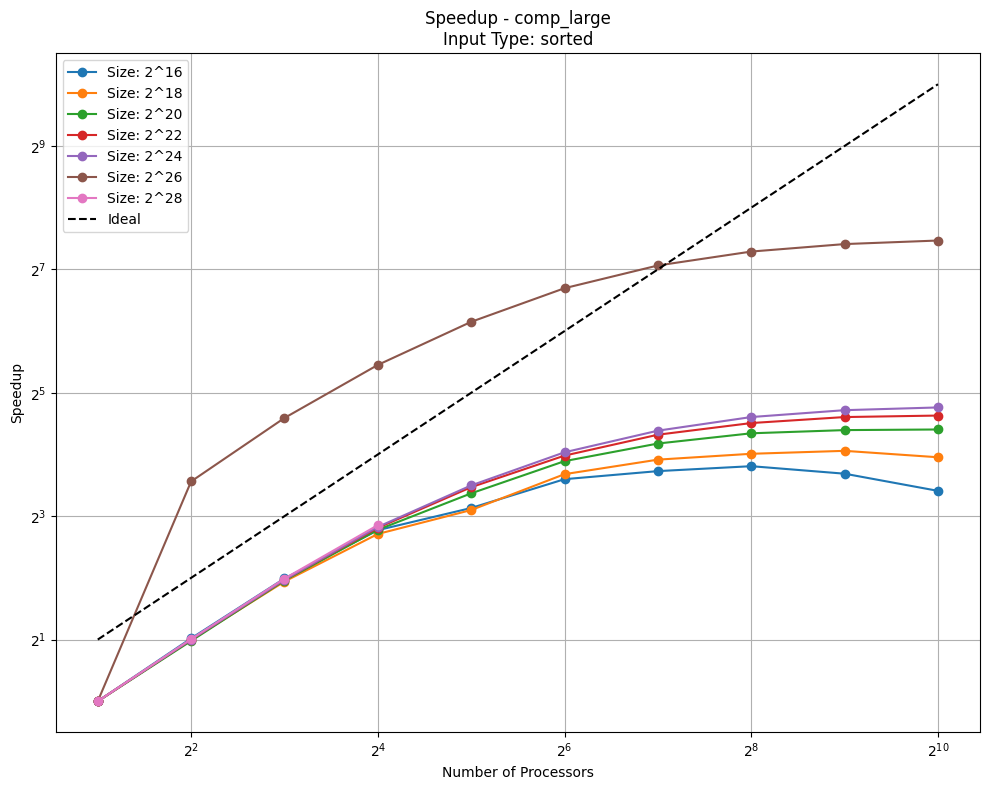

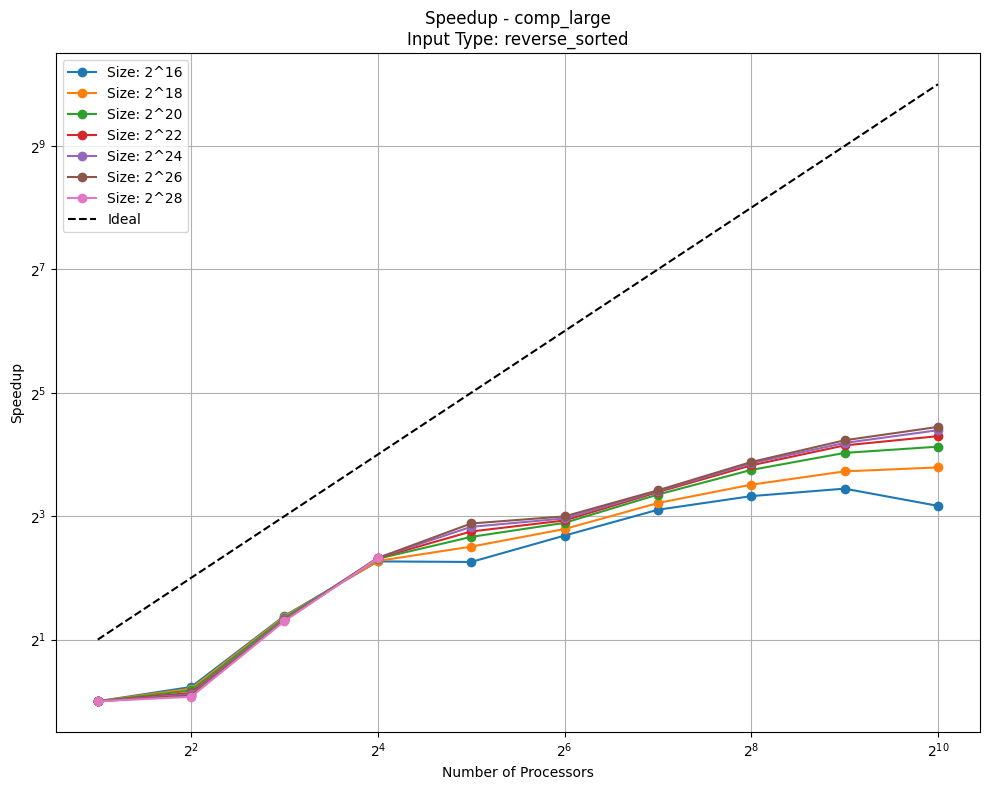

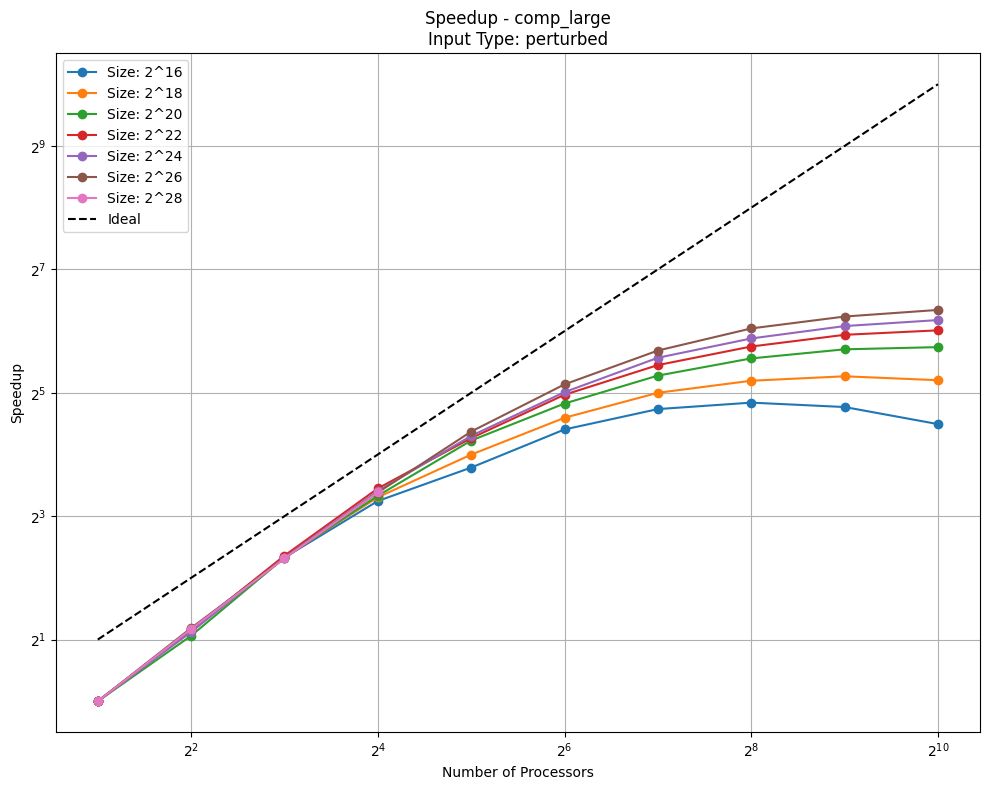

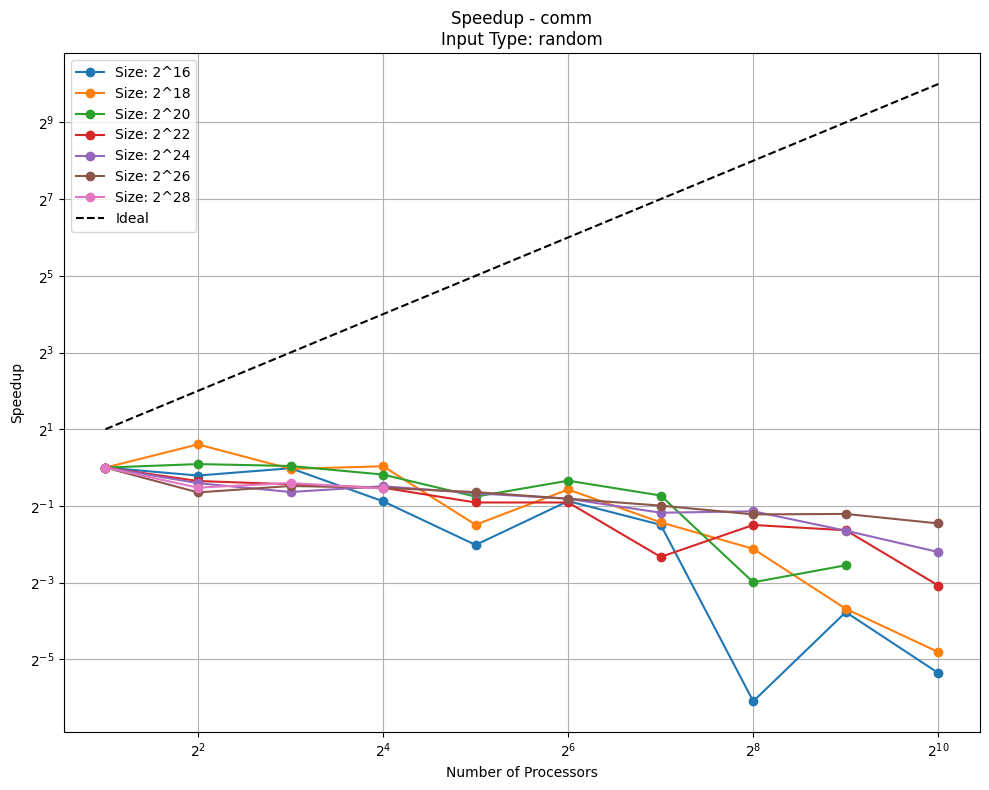

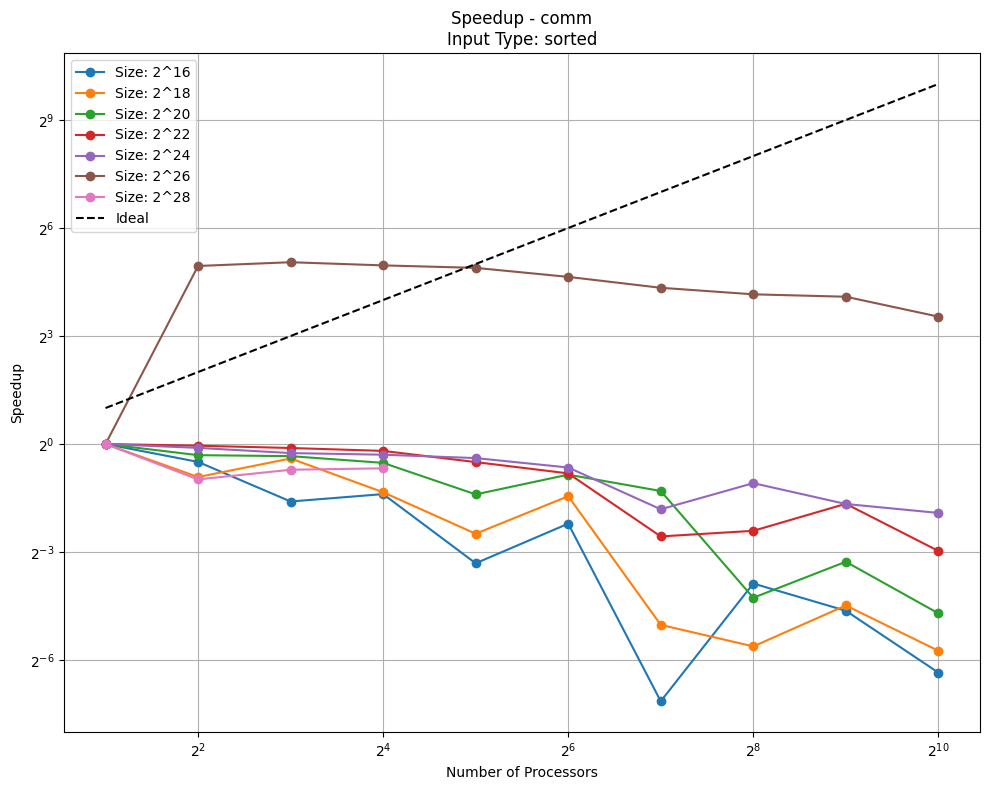

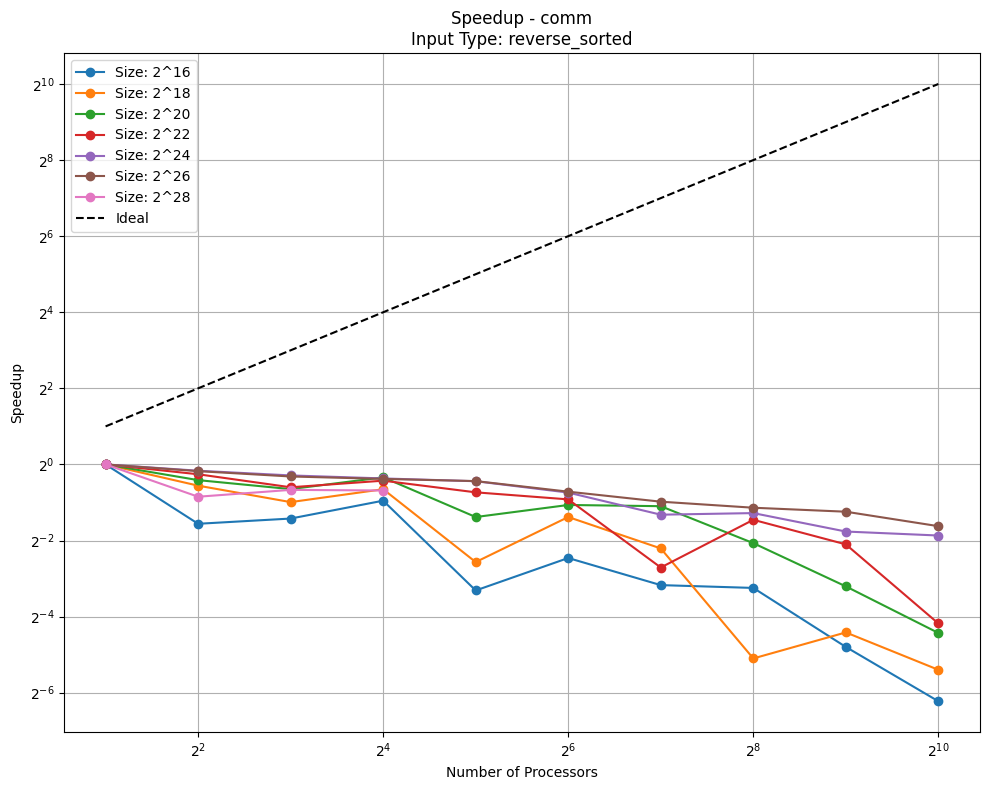

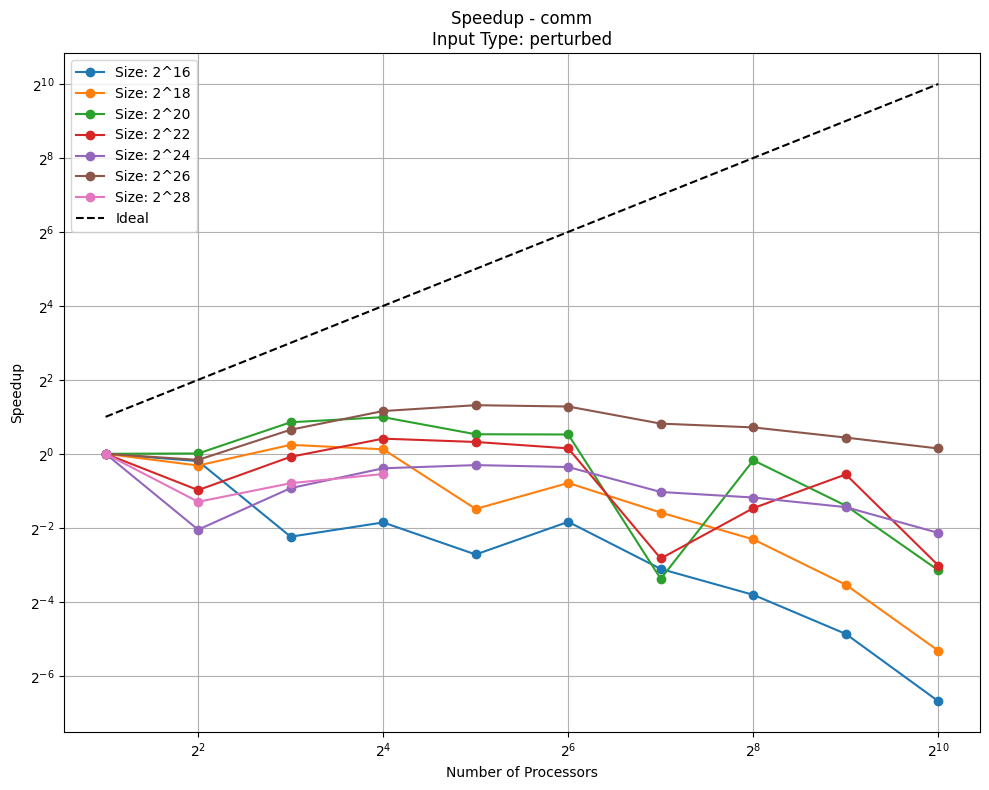

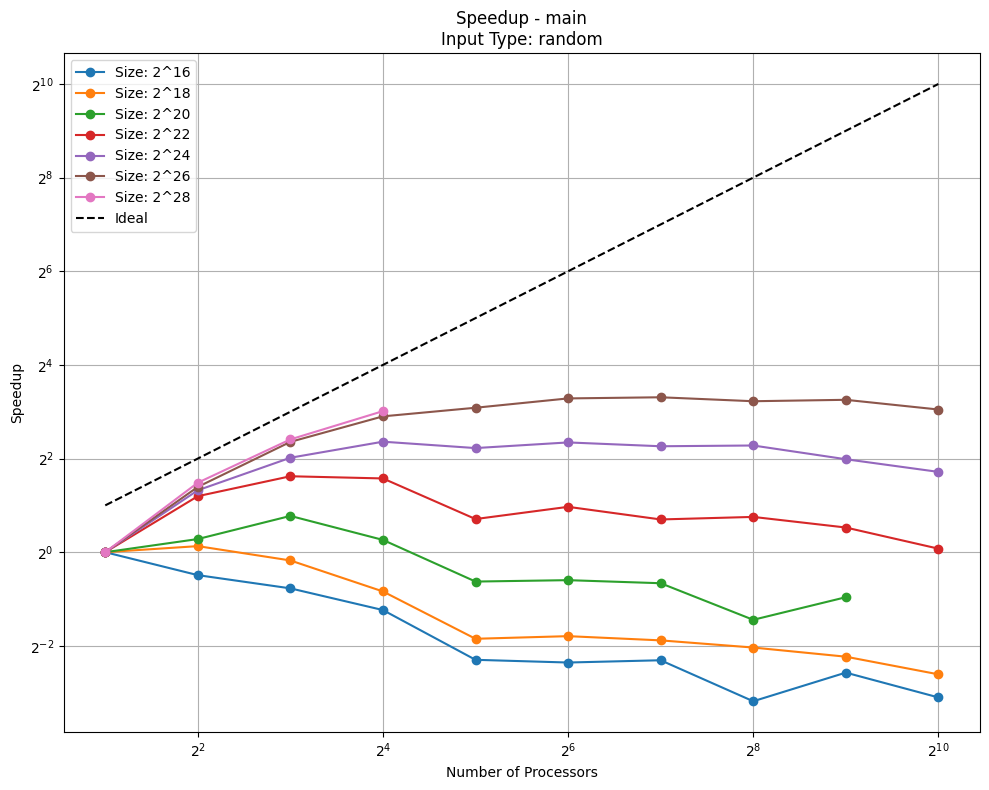

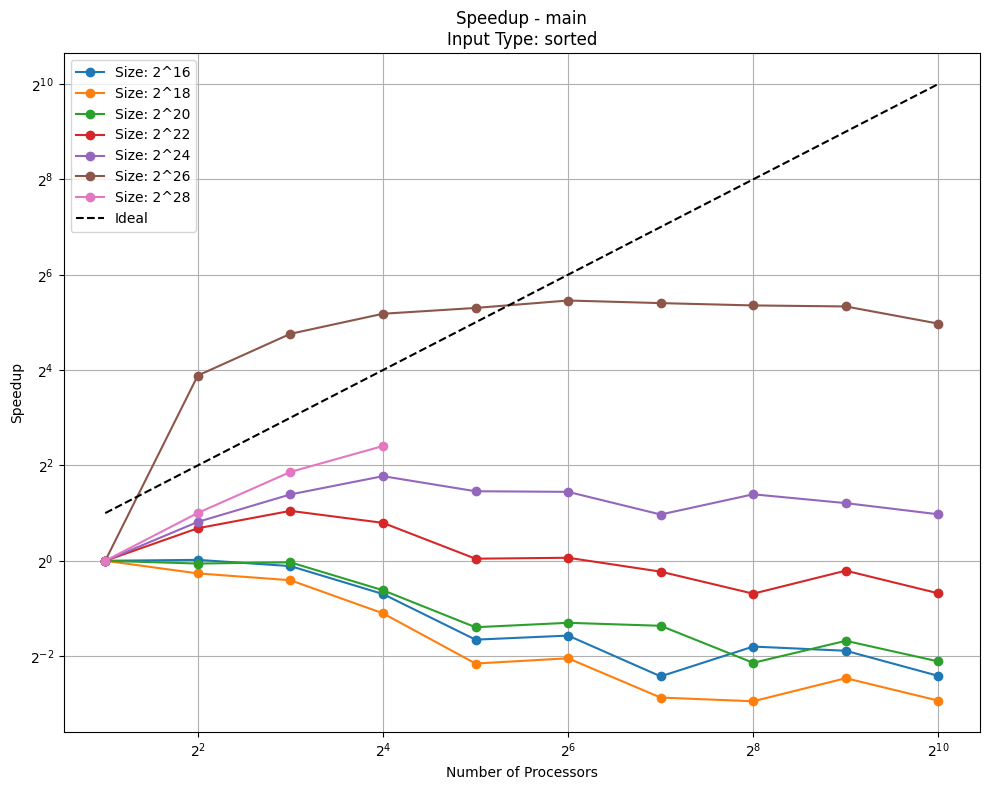

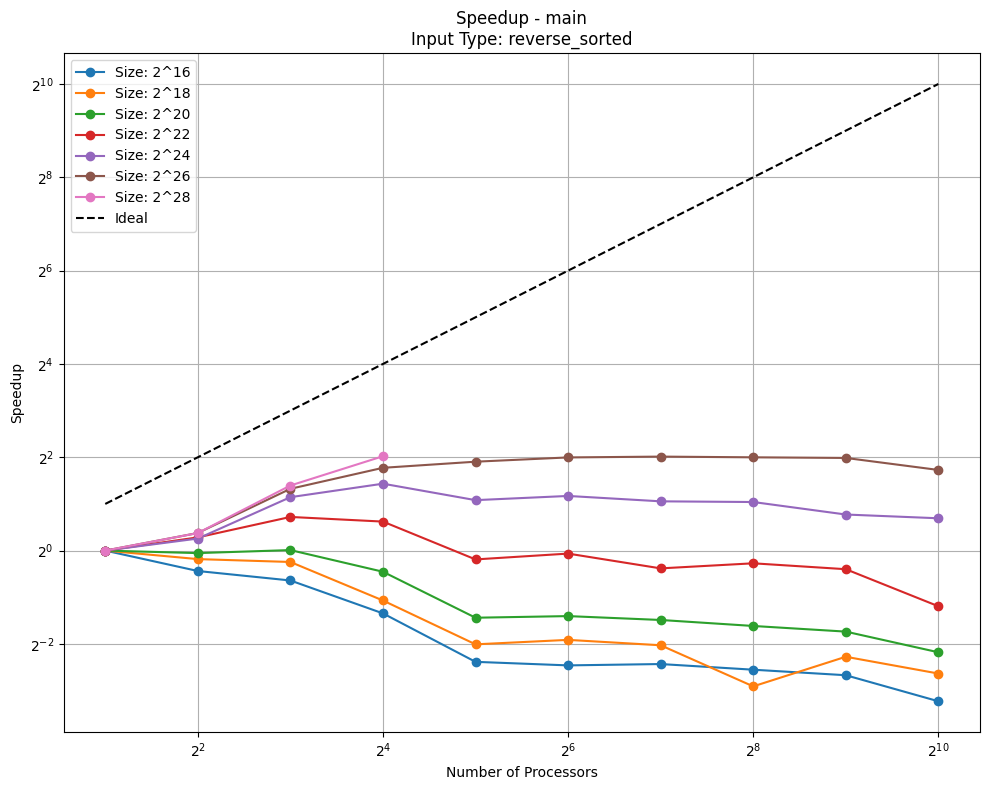

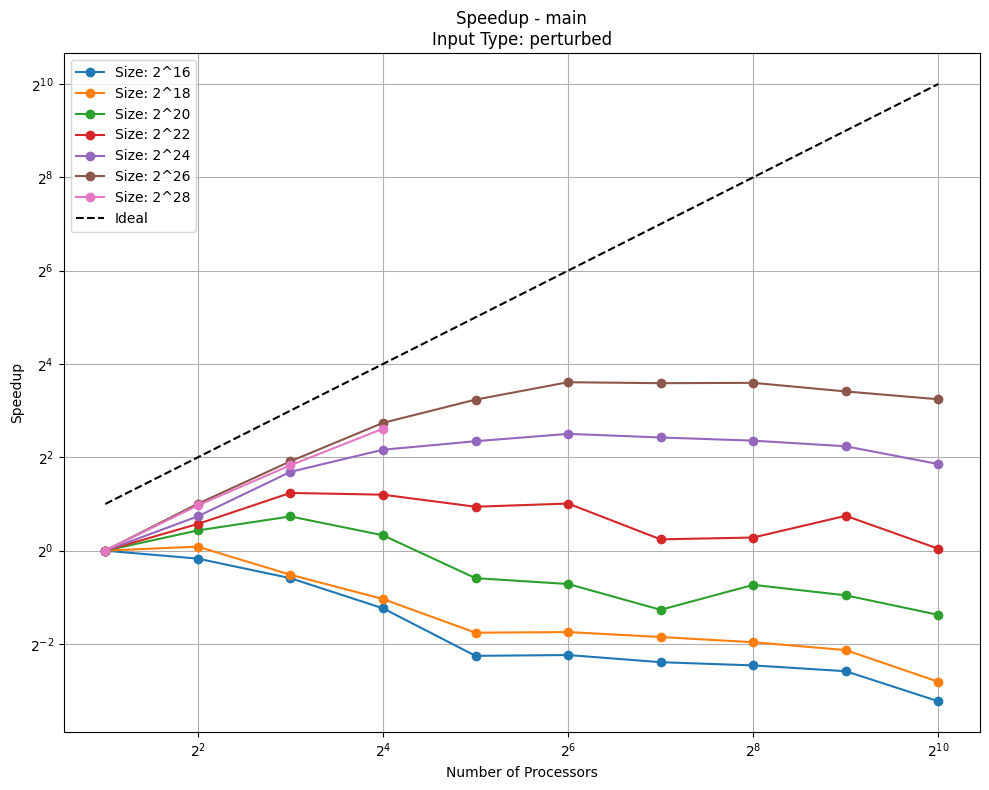


Generating Weak Scaling plots...


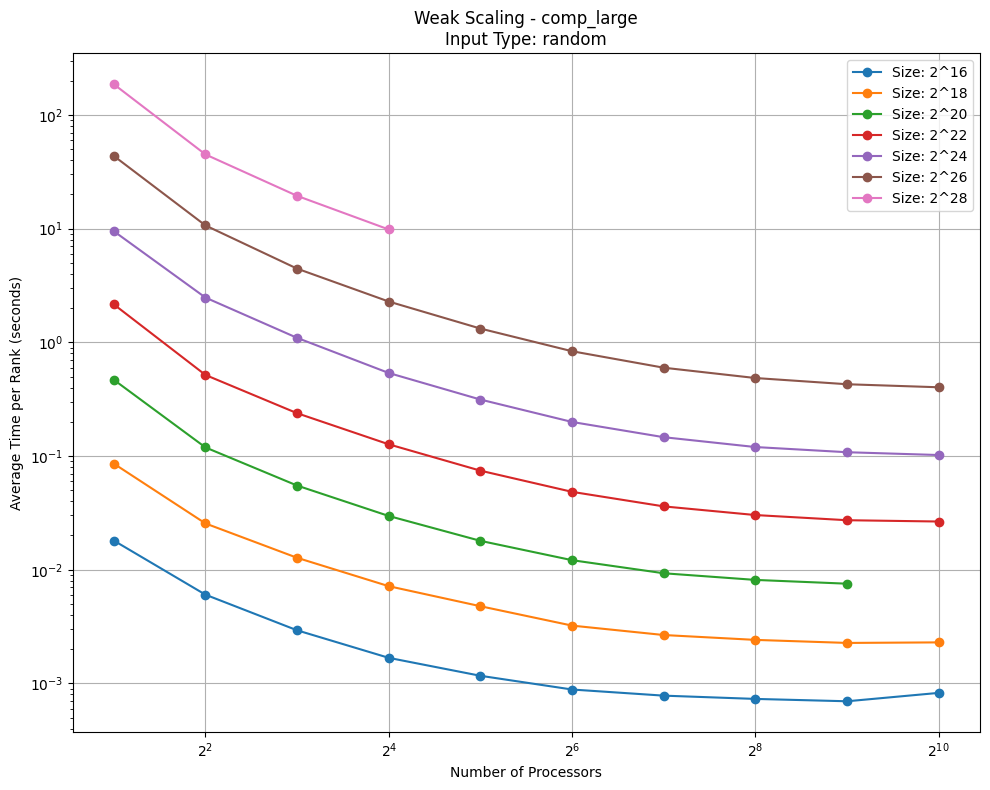

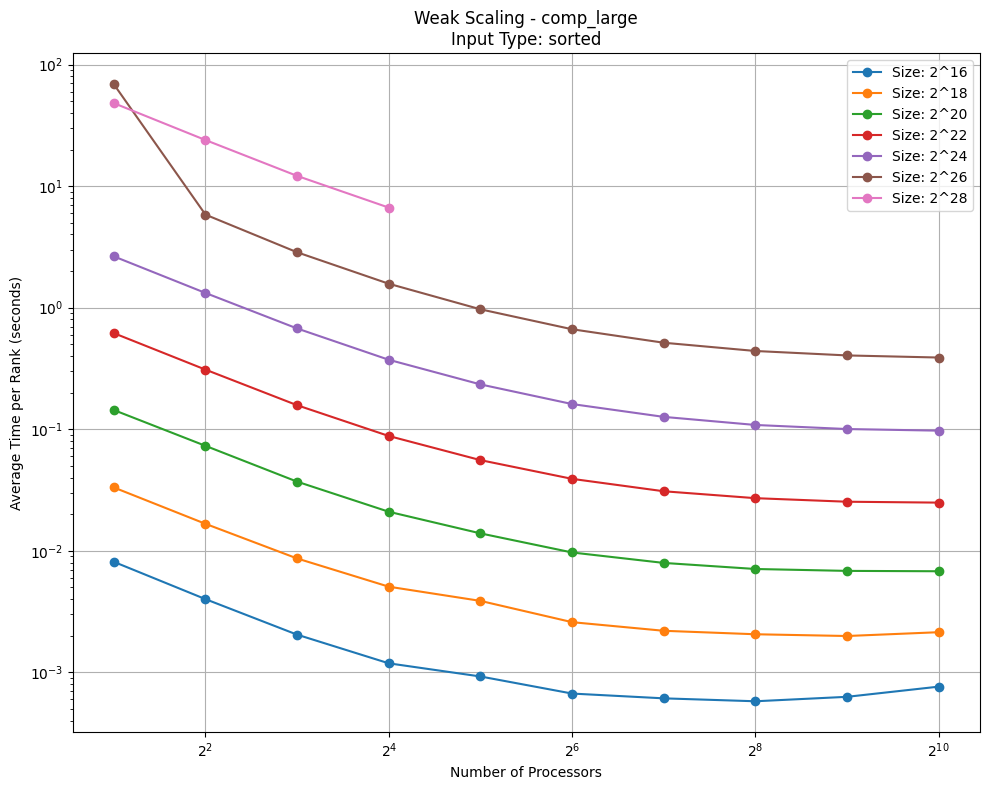

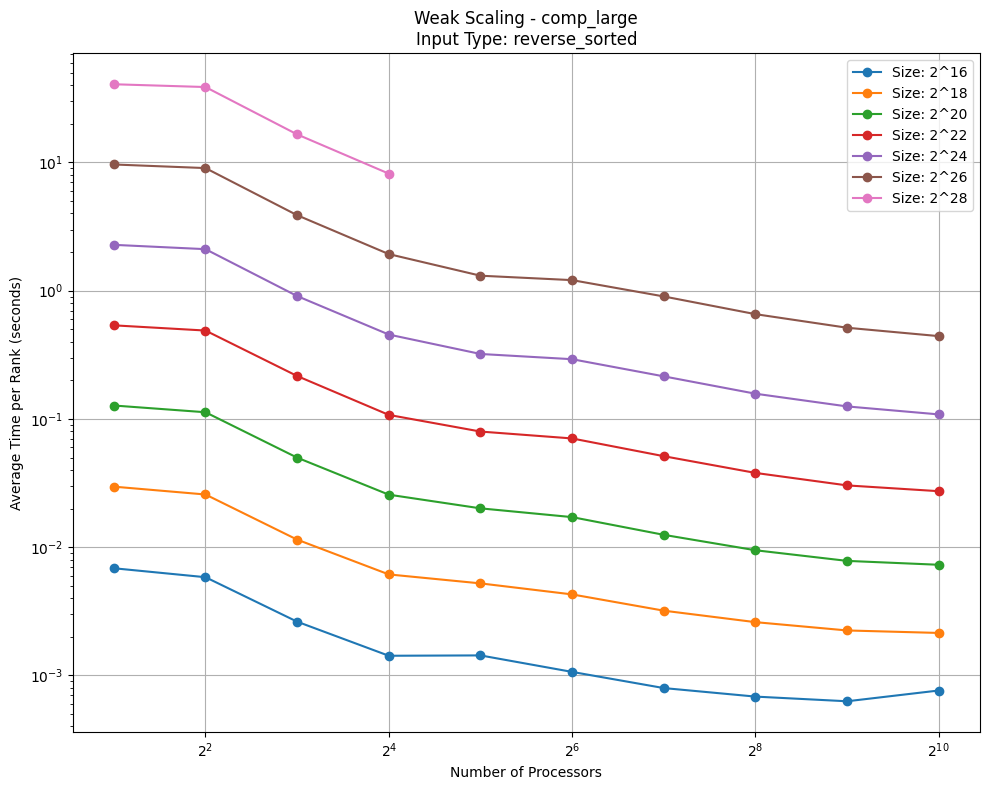

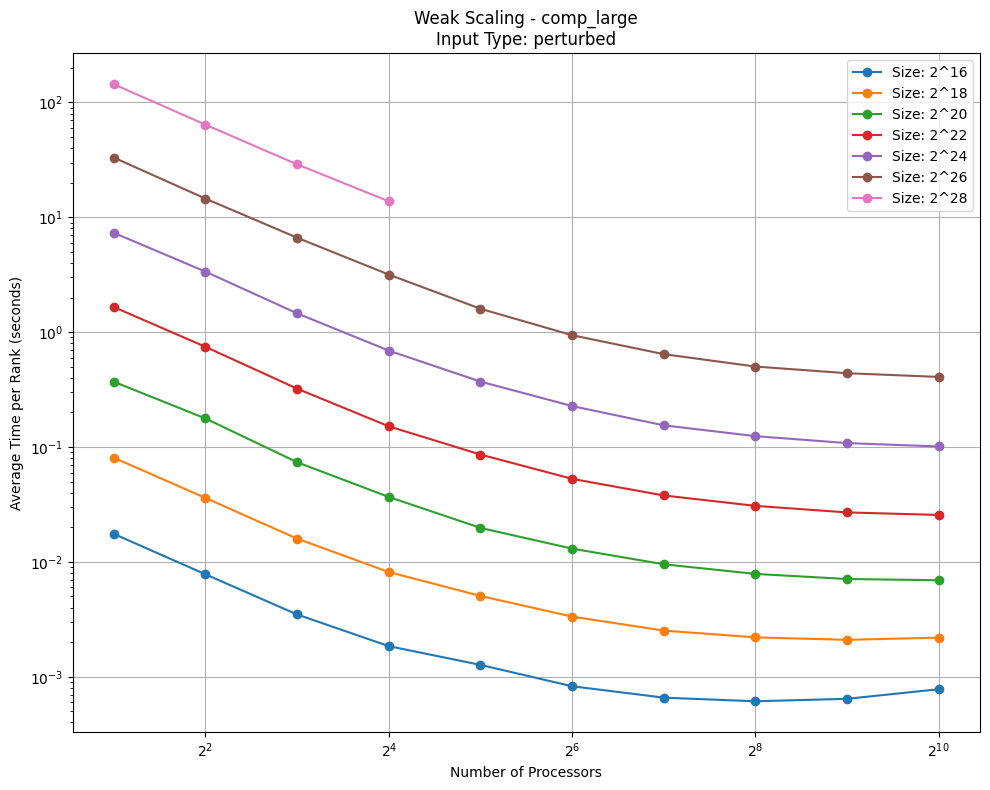

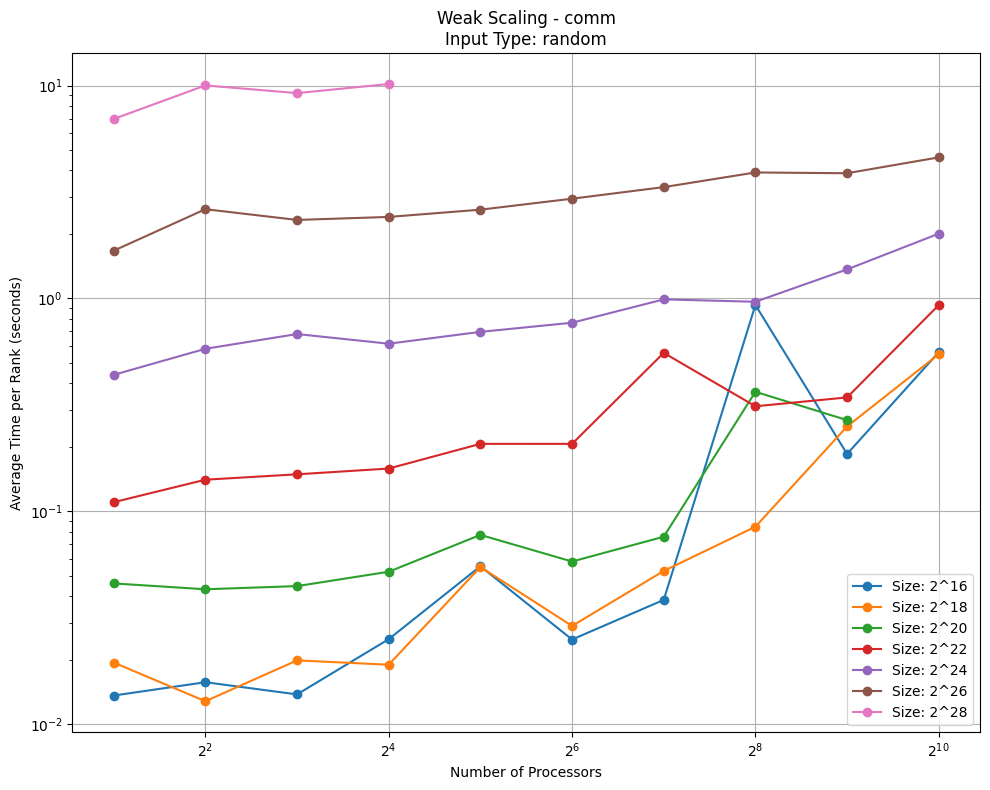

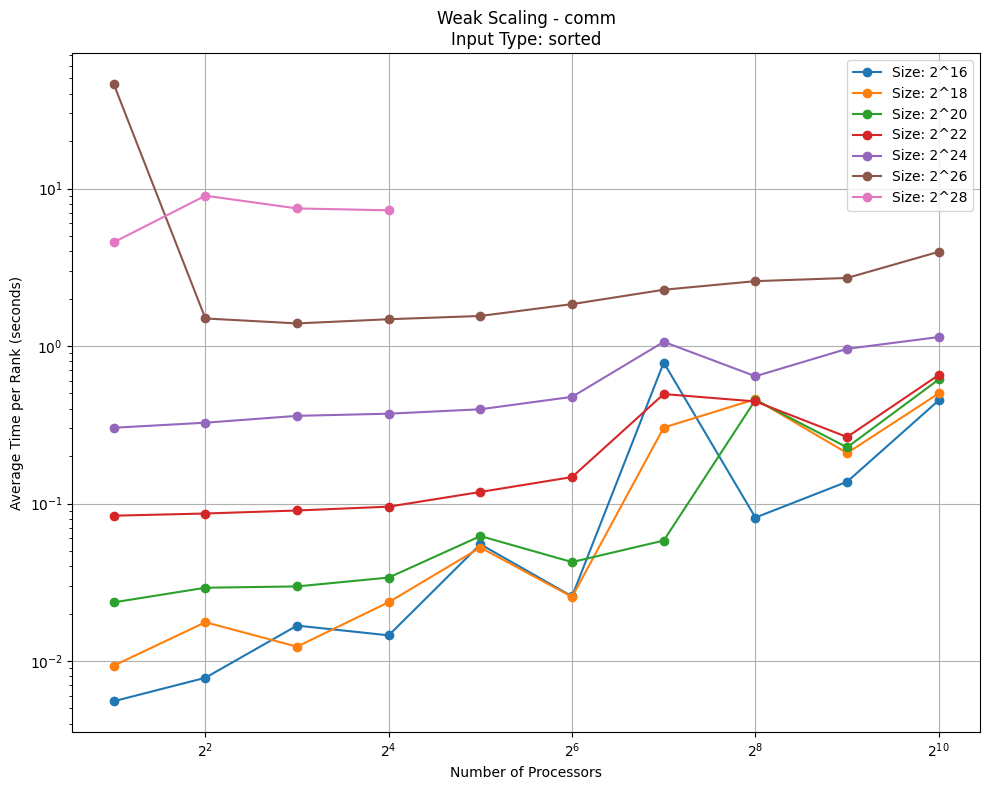

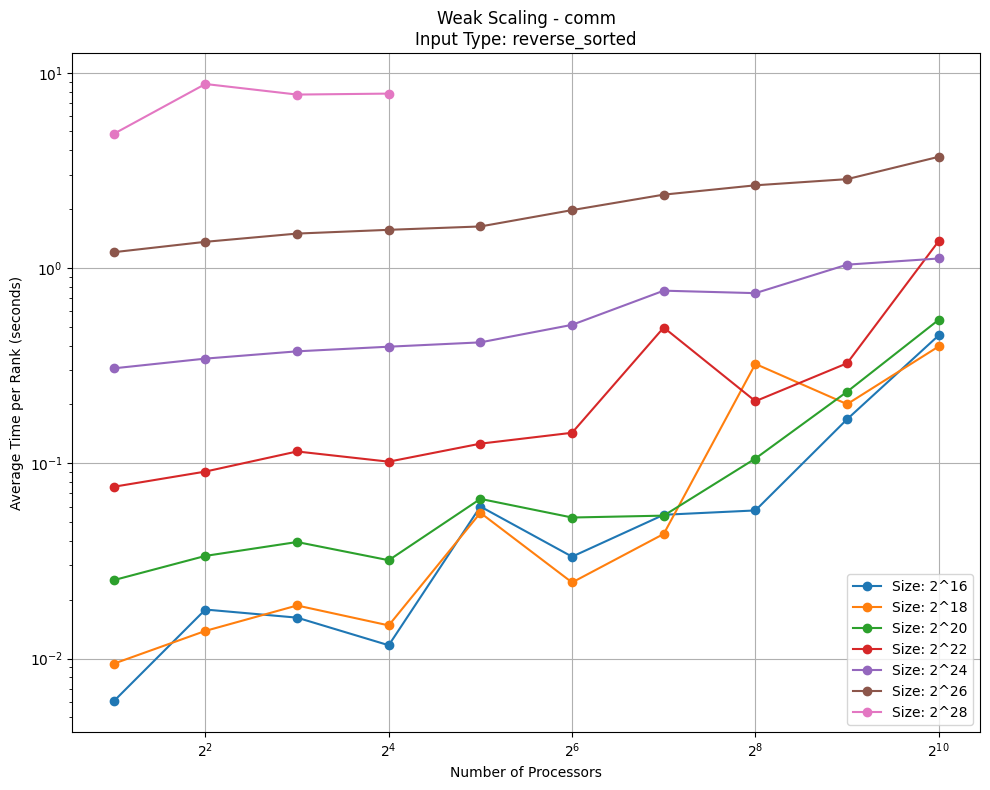

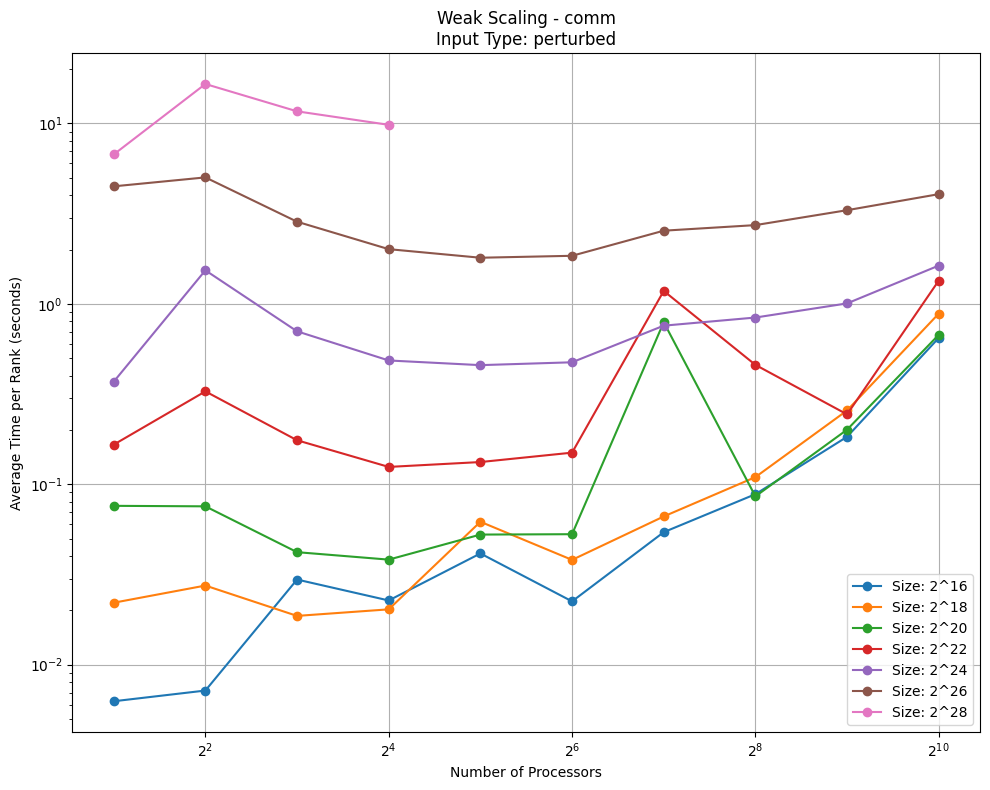

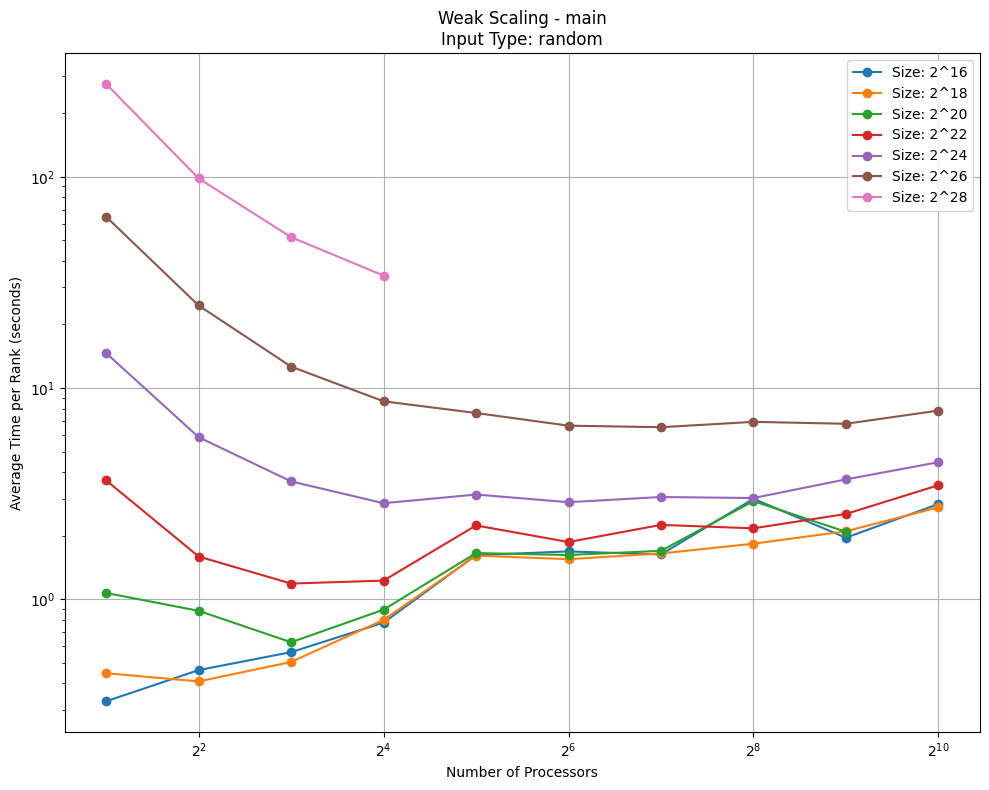

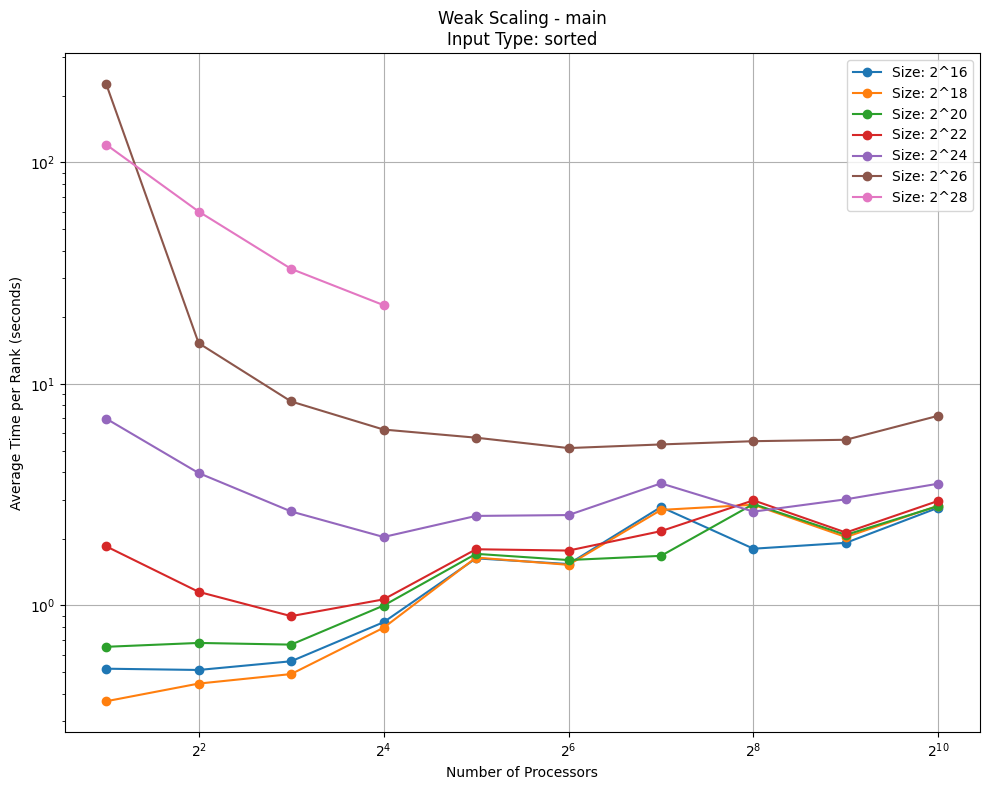

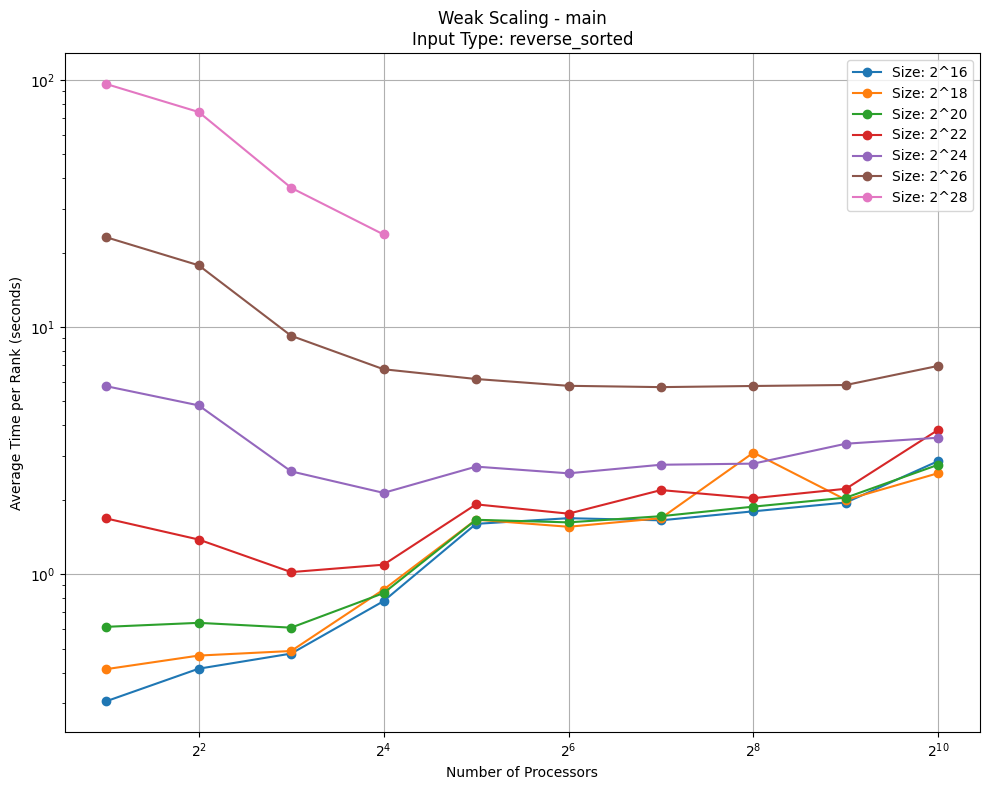

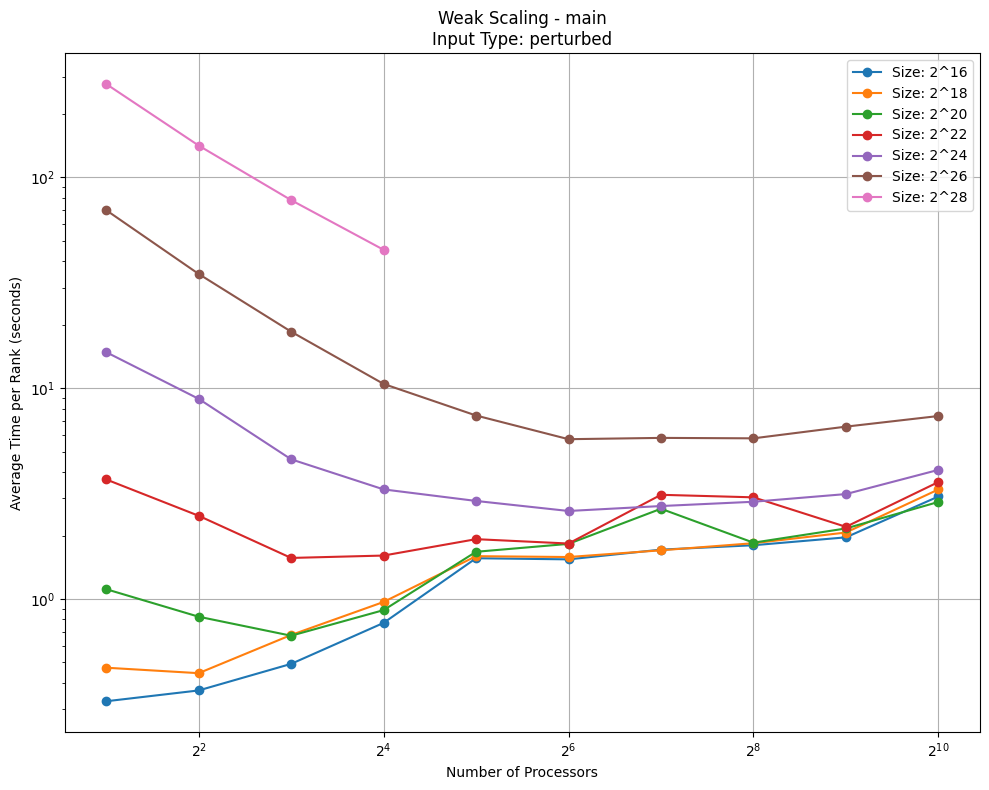


Analysis complete! Generated 45 plots:
- 21 Strong Scaling plots
- 12 Speedup plots
- 12 Weak Scaling plots


In [7]:
import sys
sys.path.append("/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
sys.path.append("/scratch/group/csce435-f24/thicket")
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import thicket as th

def load_data():
    """Load and prepare the basic dataframes"""
    tk = th.Thicket.from_caliperreader(glob("calipers/*.cali"))
    
    # Create separate dataframes for each implementation
    implementations = ['comp_large', 'comm', 'main']
    dataframes = {}
    for impl in implementations:
        data = tk.dataframe[tk.dataframe['name'] == impl].copy()
        analysis_df = pd.DataFrame()
        analysis_df['filename'] = tk.metadata['spot:output']
        analysis_df['num_procs'] = tk.metadata['num_procs']
        analysis_df['input_size'] = tk.metadata['input_size']
        analysis_df['input_type'] = tk.metadata['input_type']
        analysis_df['avg_time'] = data['Avg time/rank'].values
        dataframes[impl] = analysis_df
    
    return dataframes

def create_strong_scaling_plots(dataframes):
    """Create strong scaling plots for each implementation and input size"""
    implementations = list(dataframes.keys())
    input_types = ['random', 'sorted', 'reverse_sorted', 'perturbed']
    colors = ['b', 'g', 'r', 'm']
    
    for impl in implementations:
        df = dataframes[impl]
        unique_sizes = sorted(df['input_size'].unique())
        
        # Create a plot for each input size
        for size in unique_sizes:
            fig, ax = plt.subplots(figsize=(10, 8))
            size_data = df[df['input_size'] == size]
            
            for input_type, color in zip(input_types, colors):
                data = size_data[size_data['input_type'] == input_type].sort_values('num_procs')
                if not data.empty:
                    ax.plot(data['num_procs'], data['avg_time'], 'o-', 
                           color=color, label=input_type)
            
            ax.set_title(f'Strong Scaling - {impl}\nInput Size: 2^{size.bit_length()-1}')
            ax.set_xlabel('Number of Processors')
            ax.set_ylabel('Average Time per Rank (seconds)')
            ax.grid(True)
            ax.set_xscale('log', base=2)
            ax.set_yscale('log')
            ax.legend()
            plt.tight_layout()
            plt.show()

def create_speedup_plots(dataframes):
    """Create speedup plots for each implementation and input type"""
    implementations = list(dataframes.keys())
    input_types = ['random', 'sorted', 'reverse_sorted', 'perturbed']
    
    for impl in implementations:
        fig, ax = plt.subplots(figsize=(10, 8))
        df = dataframes[impl]
        
        for input_type in input_types:
            type_data = df[df['input_type'] == input_type].sort_values('num_procs')
            if not type_data.empty:
                # Get the base time (time with minimum number of processors)
                base_time = type_data['avg_time'].iloc[0]
                speedup = base_time / type_data['avg_time']
                ax.plot(type_data['num_procs'], speedup, 'o-', label=input_type)
        
        # Add ideal speedup line
        max_procs = df['num_procs'].max()
        ideal_x = [1, max_procs]
        ideal_y = [1, max_procs]
        ax.plot(ideal_x, ideal_y, 'k--', label='Ideal')
        
        ax.set_title(f'Speedup - {impl}')
        ax.set_xlabel('Number of Processors')
        ax.set_ylabel('Speedup')
        ax.grid(True)
        ax.set_xscale('log', base=2)
        ax.set_yscale('log', base=2)
        ax.legend()
        plt.tight_layout()
        plt.show()

def create_weak_scaling_plots(dataframes):
    """Create weak scaling plots for each implementation and input type"""
    implementations = list(dataframes.keys())
    input_types = ['random', 'sorted', 'reverse_sorted', 'perturbed']
    
    for impl in implementations:
        fig, ax = plt.subplots(figsize=(10, 8))
        df = dataframes[impl]
        
        for input_type in input_types:
            type_data = df[df['input_type'] == input_type].copy()
            if not type_data.empty:
                # For weak scaling, we want to ensure problem size scales with number of processors
                # Assuming problem size should double when processors double
                type_data['problem_size_per_proc'] = type_data['input_size'] / type_data['num_procs']
                
                # Group by number of processors and get average time
                weak_scaling_data = type_data.groupby('num_procs')['avg_time'].mean()
                ax.plot(weak_scaling_data.index, weak_scaling_data.values, 'o-', label=input_type)
        
        ax.set_title(f'Weak Scaling - {impl}')
        ax.set_xlabel('Number of Processors')
        ax.set_ylabel('Average Time per Rank (seconds)')
        ax.grid(True)
        ax.set_xscale('log', base=2)
        ax.set_yscale('log')
        ax.legend()
        plt.tight_layout()
        plt.show()

def main():
    # Load all data
    dataframes = load_data()
    
    # Generate all plots
    print("Generating Strong Scaling plots...")
    create_strong_scaling_plots(dataframes)
    
    print("Generating Speedup plots...")
    create_speedup_plots(dataframes)
    
    print("Generating Weak Scaling plots...")
    create_weak_scaling_plots(dataframes)
    
    print("Analysis complete!")

if __name__ == "__main__":
    main()


Generating weak scaling plot for comm...


(2/2) Creating Thicket: 100%|██████████| 254/254 [00:01<00:00, 148.69it/s]
/opt/homebrew/lib/python3.12/site-packages/thicket/ensemble.py:409: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace({numerical_fill_value: None}, inplace=True)


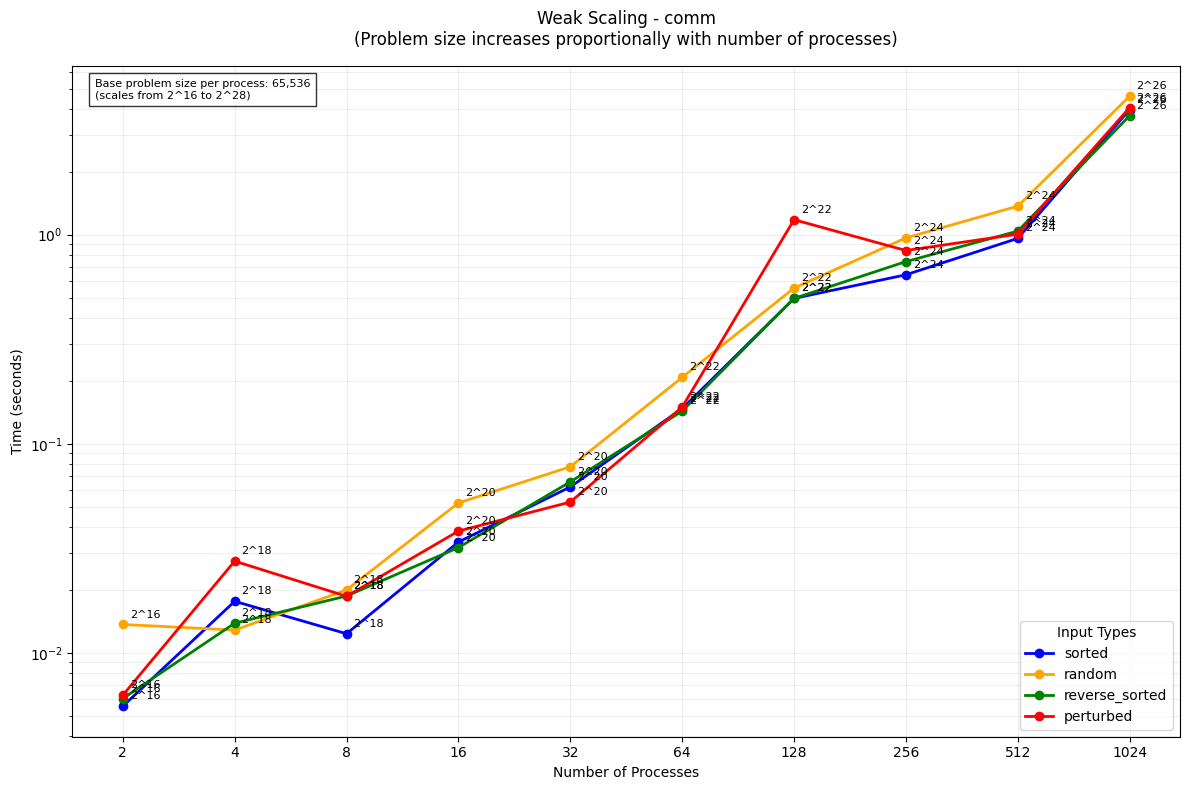


Generating weak scaling plot for comp_large...


(2/2) Creating Thicket: 100%|██████████| 254/254 [00:01<00:00, 176.02it/s]
/opt/homebrew/lib/python3.12/site-packages/thicket/ensemble.py:409: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace({numerical_fill_value: None}, inplace=True)


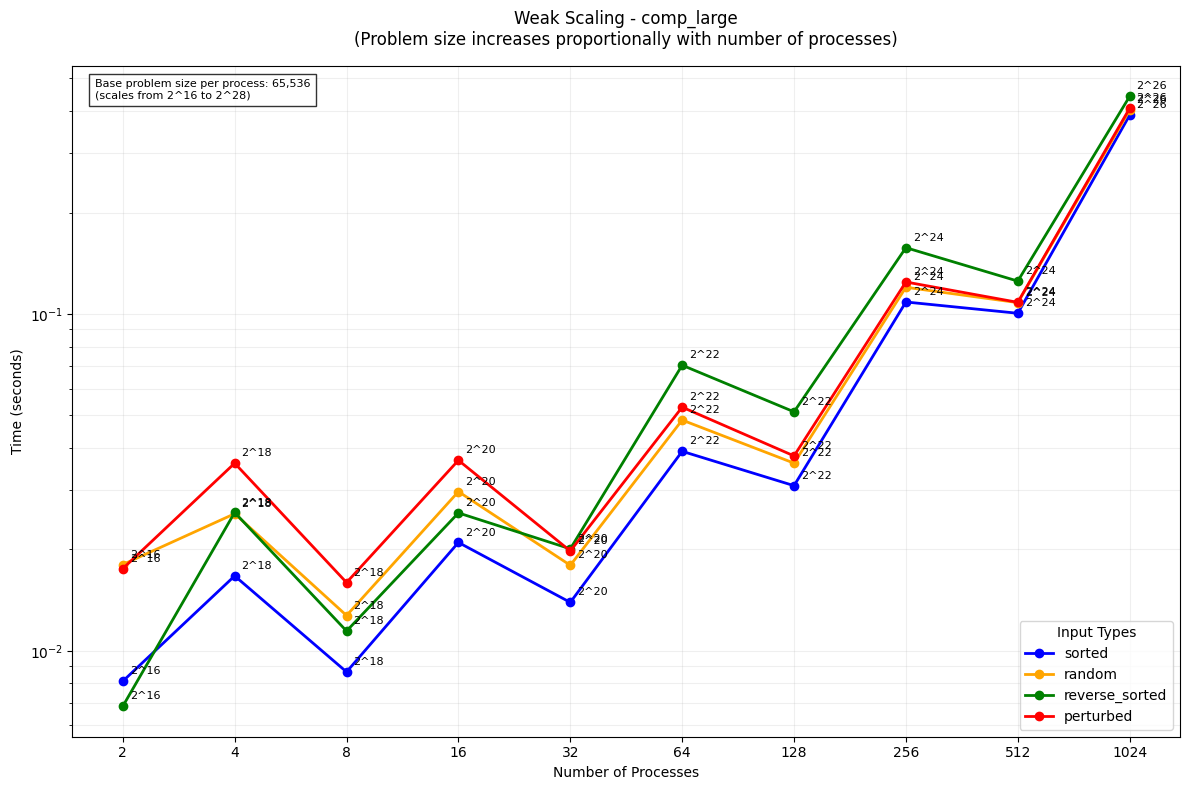


Generating weak scaling plot for main...


(2/2) Creating Thicket: 100%|██████████| 254/254 [00:01<00:00, 157.63it/s]
/opt/homebrew/lib/python3.12/site-packages/thicket/ensemble.py:409: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace({numerical_fill_value: None}, inplace=True)


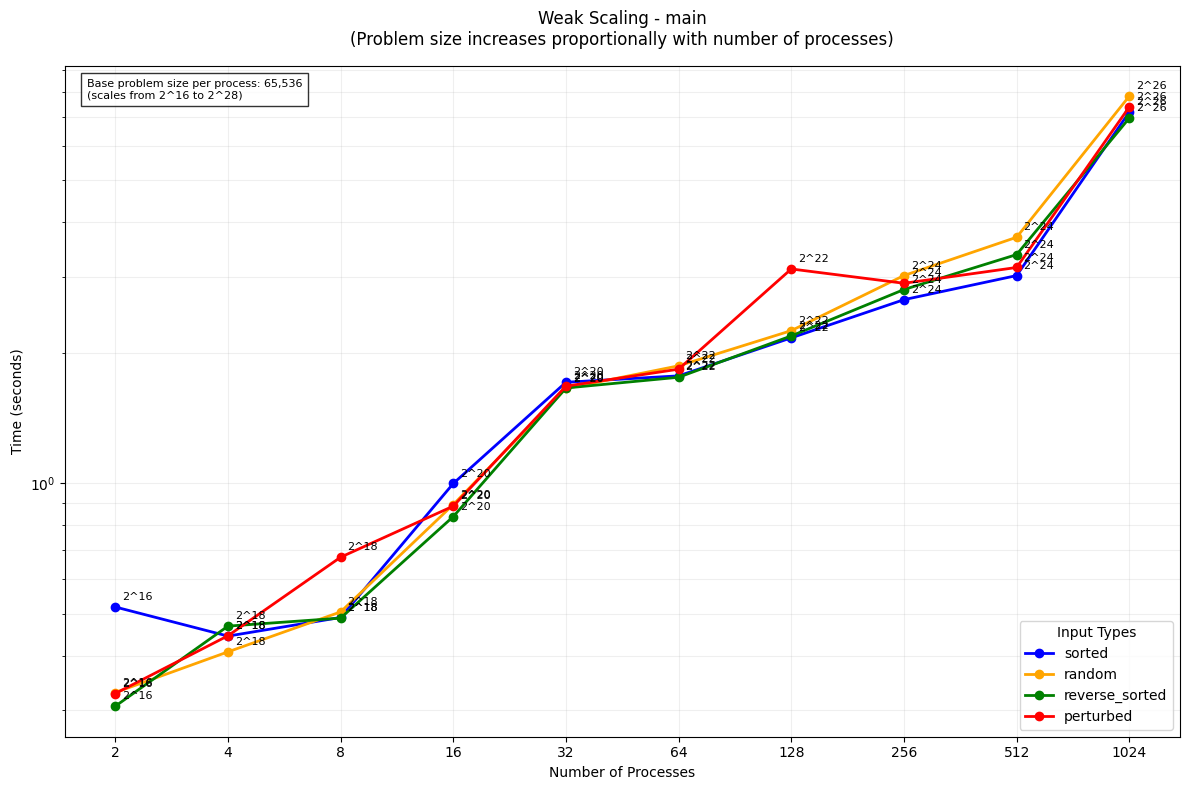

In [12]:
import sys
sys.path.append("/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
sys.path.append("/scratch/group/csce435-f24/thicket")
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import thicket as th

def create_weak_scaling_plot(implementation):
    # Load data
    tk = th.Thicket.from_caliperreader(glob("calipers/*.cali"))
    
    # Create dataframe for this implementation
    data = tk.dataframe[tk.dataframe['name'] == implementation].copy()
    df = pd.DataFrame()
    df['num_procs'] = tk.metadata['num_procs']
    df['input_size'] = tk.metadata['input_size']
    df['input_type'] = tk.metadata['input_type']
    df['avg_time'] = data['Avg time/rank'].values
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    colors = {
        'sorted': 'blue',
        'random': 'orange',
        'reverse_sorted': 'green',
        'perturbed': 'red'
    }
    
    # Create mapping of processes to desired problem sizes
    # For weak scaling: problem_size = base_size * num_procs
    base_size = 2**16  # Starting with 2^16 for smallest process count
    process_counts = sorted(df['num_procs'].unique())
    
    for input_type, color in colors.items():
        type_data = df[df['input_type'] == input_type].copy()
        weak_scaling_points = []
        
        # For each process count, find the closest matching problem size
        for proc in process_counts:
            target_size = base_size * proc  # This is what we want for weak scaling
            if target_size > 2**28:  # Skip if we exceed 2^28
                continue
                
            # Find the closest available problem size
            available_sizes = type_data[type_data['num_procs'] == proc]['input_size'].unique()
            if len(available_sizes) > 0:
                closest_size = available_sizes[np.abs(available_sizes - target_size).argmin()]
                row = type_data[
                    (type_data['num_procs'] == proc) & 
                    (type_data['input_size'] == closest_size)
                ].iloc[0]
                weak_scaling_points.append(row)
        
        if weak_scaling_points:
            weak_df = pd.DataFrame(weak_scaling_points)
            plt.plot(weak_df['num_procs'], 
                    weak_df['avg_time'], 
                    'o-', 
                    color=color, 
                    label=input_type,
                    linewidth=2)
            
            # Annotate problem sizes
            for _, row in weak_df.iterrows():
                size_power = int(np.log2(row['input_size']))
                plt.annotate(f'2^{size_power}', 
                           (row['num_procs'], row['avg_time']),
                           textcoords="offset points",
                           xytext=(5, 5),
                           ha='left',
                           fontsize=8)
    
    plt.title(f'Weak Scaling - {implementation}\n(Problem size increases proportionally with number of processes)', 
             fontsize=12, pad=15)
    plt.xlabel('Number of Processes')
    plt.ylabel('Time (seconds)')
    plt.xscale('log', base=2)
    plt.yscale('log')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend(title="Input Types")
    
    # Add base problem size information
    plt.text(0.02, 0.98, 
             f'Base problem size per process: {base_size:,}\n(scales from 2^16 to 2^28)',
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top',
             fontsize=8)
    
    # Set x-axis ticks
    plt.xticks(process_counts, process_counts)
    
    plt.tight_layout()
    plt.show()

# Create separate plots for each implementation
for impl in ['comm', 'comp_large', 'main']:
    print(f"\nGenerating weak scaling plot for {impl}...")
    create_weak_scaling_plot(impl)
    
    # Add a small delay to ensure plots don't overlap
    plt.pause(1)